In [2]:
DEBUG = False

In [3]:
import os
import gc
import cv2
import time
import timm
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import albumentations
from pylab import rcParams
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
from torch.utils.data import  Dataset
import torch.nn.functional as F

%matplotlib inline
rcParams['figure.figsize'] = 20, 8
device = torch.device('cuda')
torch.backends.cudnn.benchmark = True

# Config

In [4]:
kernel_type = '0920_1bonev2_effv2s_224_15_6ch_augv2_mixupp5_drl3_rov1p2_bs8_lr23e5_eta23e6_50ep'
load_kernel = None
load_last = True

n_folds = 5
#backbone = 'tf_efficientnetv2_s.in21k_ft_in1k'
#backbone="tf_efficientnetv2_b3.in21k_ft_in1k"
backbone="tf_efficientnetv2_b2.in1k"

image_size = 296

n_slice_per_c = 24 # liver,spleen,left kidney, right kidney 
in_chans = 4

init_lr = 2.0e-4
eta_min = 0
batch_size = 3
drop_rate = 0.
drop_rate_last = 0.5 #  0.1
drop_path_rate = 0.2
p_mixup = 0.4 #0 0.3
p_rand_order_v1 = 0.2

data_dir = './preprocessed2'
use_amp = True
num_workers = 6
out_dim = 3

n_epochs = 60

log_dir = './logs'
model_dir = './models_cls'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [5]:
border_mode=cv2.BORDER_CONSTANT
transforms_train = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
    albumentations.HorizontalFlip(p=0.3),
    albumentations.VerticalFlip(p=0.3),
    albumentations.Transpose(p=0.3),
    albumentations.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.05, brightness_by_max=False, always_apply=False, p=0.3),

    #border_mode=cv2.BORDER_REFLECT101
    albumentations.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20, border_mode=border_mode, p=0.5),

    albumentations.OneOf([
        albumentations.MotionBlur(blur_limit=3),
        albumentations.MedianBlur(blur_limit=3),
        albumentations.GaussianBlur(blur_limit=(1,3)),
        albumentations.GaussNoise(var_limit=(3.0, 9.0)),
    ], p=0.3),
    #albumentations.OneOf([
        #albumentations.OpticalDistortion(distort_limit=.3),
    #    albumentations.GridDistortion(num_steps=4, distort_limit=.2),
    #], p=0.3),
    albumentations.GridDistortion(num_steps=4, distort_limit=.3),
    albumentations.Cutout(max_h_size=int(image_size * 0.5), max_w_size=int(image_size * 0.5), num_holes=1, p=0.4),
])

transforms_valid = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
])

/home/sronen/code/.venv/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


# DataFrame

In [6]:
from sklearn.model_selection import KFold

organ_dict = {
    0: 'liver',
    1: 'spleen',
    2: 'kidney',
}

df_p = pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/train.csv')





df_s=pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/train_series_meta.csv')

df_p['fold'] = -1
kf = KFold(5,shuffle=True,random_state=42)
for fold, (train_idx, valid_idx) in enumerate(kf.split(df_p,df_p)):
    df_p.loc[valid_idx, 'fold'] = fold


#df_healthy=df_p[df_p["any_injury"]==0].sample(758)
#df_injured=df_p[(df_p["kidney_healthy"]==0) | (df_p["liver_healthy"]==0)| (df_p["spleen_healthy"]==0) | (df_p["bowel_healthy"]==0)]
#print(len(df_injured),len(df_healthy))
#df_p1=pd.concat((df_healthy,df_injured))


df=df_p.merge(df_s,on="patient_id")
df["count"]=df.groupby(["patient_id"])["patient_id"].transform("count")


pid=[]
sid = []
cs = []
label = []
label1=[]
fold = []
hu=[]
counts=[]
for row in df.to_dict(orient="records"):
    for i in [0,1,2]:
        pid.append(row["patient_id"])
        sid.append(row["series_id"])
        cs.append(i)
        hu.append(row["aortic_hu"])
        organ=organ_dict[i]
        la=[row[f'{organ}_healthy'],row[f'{organ}_low'],row[f'{organ}_high']]
        label.append(la)
        label1.append(np.argmax(la))
        fold.append(row["fold"])
        counts.append(row["count"])

df = pd.DataFrame({
    'patient_id': pid,
    'series_id': sid,
    'c': cs,
    'hu':hu,
    'label': label,
    'label1':label1,
    'fold': fold,
    'counts':counts,
})

df = df.sample(16).reset_index(drop=True) if DEBUG else df

df.tail(10)
print(len(df_p),len(df_s),len(df))



3147 4711 14133


# Dataset

In [6]:
class CLSDataset(Dataset):
    def __init__(self, df, mode, transform):

        self.df = df.reset_index()
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        cid = row.c
        
        images = []
        
        filepath=os.path.join(data_dir, f'{row.patient_id}_{row.series_id}.npz')
        image3d = np.load(filepath)['arr_0'] # slice,channel,H,W
        istart=n_slice_per_c*cid
        iend=istart+n_slice_per_c
        for ind in list(range(istart,iend)):
            image=image3d[ind,...].transpose(1,2,0).astype(np.uint8)
            image = self.transform(image=image)['image']
            image = image.transpose(2, 0, 1).astype(np.float32) / 255.
            images.append(image)
        images = np.stack(images, 0)

   

        if self.mode != 'test':
            images = torch.tensor(images).float()
            labels = torch.tensor([row.label] * n_slice_per_c).float()
            counts=torch.tensor([row.counts]*n_slice_per_c).float()
            
            #images[...]=0.
            #images[:,:,:,:3]=labels[:,None,None,:]
            #images[:,0,0,:3]=labels[:,:]

         
            
            if self.mode == 'train' and random.random() < p_rand_order_v1:
                indices = torch.randperm(images.size(0))
                images = images[indices]
                counts=counts[indices]

            return images, labels,counts
        else:
            return torch.tensor(images).float()

In [7]:
rcParams['figure.figsize'] = 20,8

df_show = df
dataset_show = CLSDataset(df_show, 'train', transform=transforms_train)
loader_show = torch.utils.data.DataLoader(dataset_show, batch_size=batch_size, shuffle=True, num_workers=num_workers)

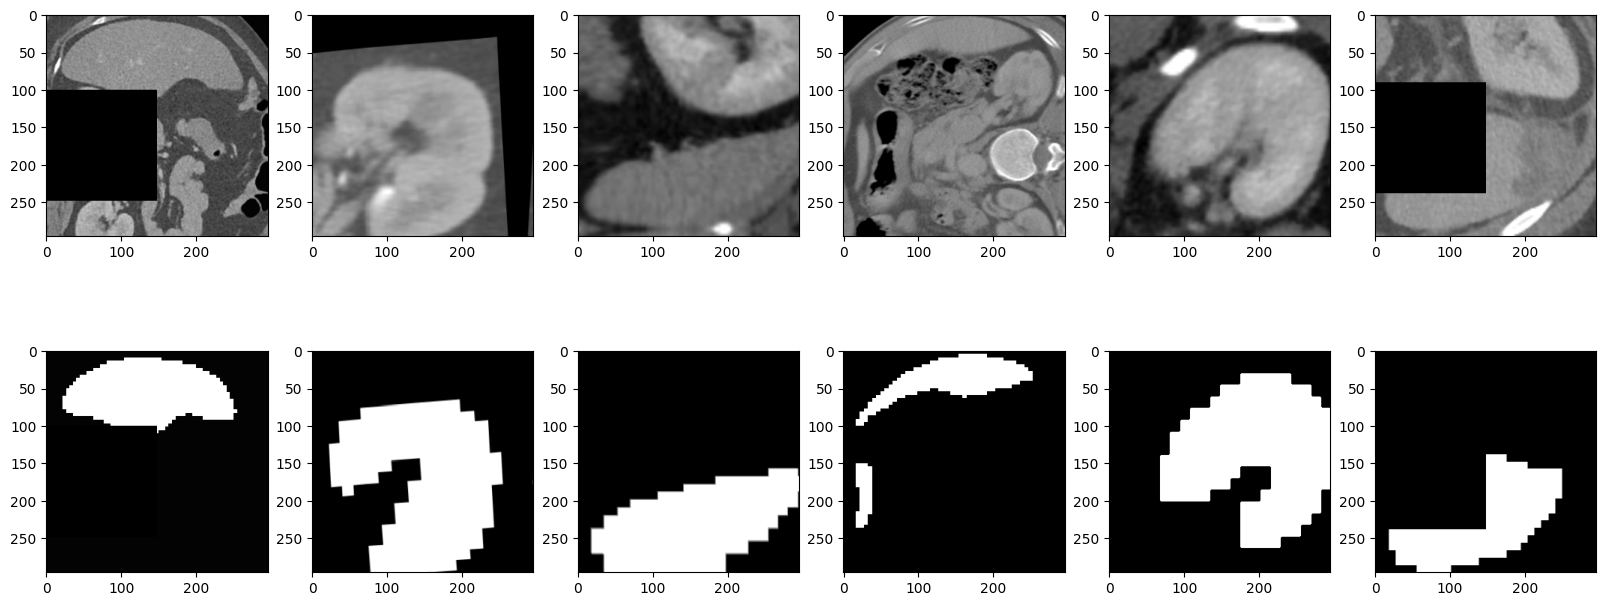

In [8]:
f, axarr = plt.subplots(2,6)
for p in range(6):
    idx = p * 20
    imgs, lbl,_ = dataset_show[idx]
    sel=7
    axarr[0, p].imshow(255*imgs[sel][1],cmap="gray")
    axarr[1, p].imshow(imgs[sel][-1],cmap="gray")

# Model

In [10]:
class TimmModel(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super(TimmModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=in_chans,
            num_classes=out_dim,
            features_only=False,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()


        self.lstm = nn.LSTM(hdim, 64, num_layers=1, dropout=drop_rate, bidirectional=True, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(drop_rate_last),
            nn.LeakyReLU(0.1),
            nn.Linear(64, out_dim),
            #NormedLinear(128,out_dim)
        )

    def forward(self, x):  # (bs, nslice, ch, sz, sz)
        bs = x.shape[0]
        x = x.view(bs * n_slice_per_c, in_chans, image_size, image_size)
        feat = self.encoder(x)
        feat = feat.view(bs, n_slice_per_c, -1)
        feat, _ = self.lstm(feat)
        feat = feat.contiguous().view(bs * n_slice_per_c, -1)
        feat = self.head(feat)
        feat = feat.view(bs, n_slice_per_c,out_dim).contiguous()

        return feat

In [11]:
m = TimmModel(backbone)
m(torch.rand(2, n_slice_per_c, in_chans, image_size, image_size)).shape

torch.Size([2, 24, 3])

In [12]:
from torchinfo import summary
summary(m,(1,n_slice_per_c,in_chans,image_size,image_size))

Layer (type:depth-idx)                             Output Shape              Param #
TimmModel                                          [1, 24, 3]                --
├─EfficientNet: 1-1                                [24, 1408]                --
│    └─Conv2dSame: 2-1                             [24, 32, 148, 148]        1,152
│    └─BatchNormAct2d: 2-2                         [24, 32, 148, 148]        64
│    │    └─Identity: 3-1                          [24, 32, 148, 148]        --
│    │    └─SiLU: 3-2                              [24, 32, 148, 148]        --
│    └─Sequential: 2-3                             [24, 208, 10, 10]         --
│    │    └─Sequential: 3-3                        [24, 16, 148, 148]        6,976
│    │    └─Sequential: 3-4                        [24, 32, 74, 74]          94,016
│    │    └─Sequential: 3-5                        [24, 56, 37, 37]          296,400
│    │    └─Sequential: 3-6                        [24, 104, 19, 19]         388,124
│    │    └─Seq

In [14]:
ce = nn.CrossEntropyLoss(reduction='none', label_smoothing=0.0)

mapping = torch.tensor([1., 2., 4.]).cuda()
mapping=mapping/torch.mean(mapping)

def criterion(logits, targets,counts=None,weights=None):
    b=logits.shape[0]
    logits=logits.view(-1,out_dim)
    targets=targets.view(-1,out_dim)
    loss = ce(logits, targets)
    ll=torch.argmax(targets,dim=1) 
    #print("logits",logits[0:5,:],"targets",ll[0:5])

    #0->1,1->2,2->4 

# Use torch.index_select to apply the mapping
    #w = torch.index_select(mapping, dim=0, index=ll)
    if weights is not None:
        w=torch.matmul(targets,mapping)
    else:
        w=torch.ones(b).float().cuda()
    if counts is not None:
        counts=counts.view(-1)
        w=w/counts
    loss=loss.reshape((b,-1))
    w=w.reshape((b,-1))
    loss=torch.mean(loss,dim=1)

    w=torch.mean(w,dim=1)
    return loss,w

In [15]:
from torch.distributions.beta import Beta
beta=Beta(torch.tensor([0.2]),torch.tensor([0.2]))

def mix_up(images1,labels1):
    # Unpack two datasets
    batch_size = images1.shape[0]
    # Sample lambda and reshape it to do the mixup
    l = beta.sample(torch.Size([batch_size])).cuda()
    x_l = l.reshape((batch_size, 1, 1, 1,1))
    y_l = l.reshape((batch_size, 1,1))
    idx = torch.randperm(batch_size).cuda()
    images2=images1[idx,...]
    labels2=labels1[idx,...]
    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images1 * x_l + images2 * (1 - x_l)
    labels = labels1 * y_l + labels2 * (1 - y_l)
    return (images, labels)


def train_func(model, loader_train, optimizer, scaler=None):
    model.train()
    train_loss = []
    ws=[]
    bar = tqdm(loader_train)
    for images, targets,_ in bar:
        optimizer.zero_grad()
        images = images.cuda()
        targets = targets.cuda()
  
        if random.random() < p_mixup:
            images, targets = mix_up(images, targets)

        if use_amp:
            with amp.autocast():
                logits = model(images)
                loss,w = criterion(logits, targets)
                loss1=torch.mean(loss*w)
            scaler.scale(loss1).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss.extend(loss.detach().cpu())

        else:
            logits = model(images)
            loss,w = criterion(logits, targets)
            loss1=torch.mean(loss*w)
            loss1.backward()
            optimizer.step()
            train_loss.extend(loss.detach().cpu())

            
        ws.extend(w.detach().cpu())
        bar.set_description(f'smth:{np.average(train_loss[-100:],weights=ws[-100:]):.4f}')

    return np.average(train_loss,weights=ws)


def valid_func(model, loader_valid,dff):
    model.eval()
    valid_loss=[]
    valid_loss_progress = []
    outputs = []
    tgs=[]
    ws=[]
    ws_progress=[]
    bar = tqdm(loader_valid)
    with torch.no_grad():
        for images, targets,counts in bar:
            images = images.cuda()
            targets = targets.cuda()
            counts=counts.cuda()

            #if use_amp:
            #    with amp.autocast():
            
            logits = model(images)
            blogits=torch.mean(logits,dim=1) # average logits across slices
            loss,w=criterion(logits,targets,counts,mapping)

            ws_progress.extend(w.cpu())
            valid_loss_progress.extend(loss.cpu())
            out=torch.unbind(blogits,dim=0)   
            outputs.extend(out)
            tt=targets[:,0,:] # first slice
            tgs.extend(torch.unbind(tt,dim=0))
            bar.set_description(f'smth:{np.average(valid_loss_progress[-100:],weights=ws_progress[-100:]):.4f}')
        for pid in dff["patient_id"].unique():
            for c in range(3):
                #print("patient",pid,"organ",c)
                inds=dff[(dff["patient_id"]==pid) & (dff["c"]==c)].index.values
                #print(pid,c,inds[0],dff.iloc[inds[0]])
                la=torch.mean(torch.stack([outputs[i] for i in inds]),dim=0) # average logits across up to two series per patient
                ta=tgs[inds[0]]

                loss = ce(la[None,:], ta[None,:])
                #print("fpatient id {pid}, organ {c}, {la} , {ta}, {loss}")
                valid_loss.append(loss.item())
                ta=torch.argmax(ta)
                w=mapping[ta].item()
                #print(ta.item(),dff.iloc[inds[0]]["label1"])
                assert ta.item()==dff.iloc[inds[0]]["label1"]
                ws.append(w)
        
        valid_loss=np.average(valid_loss,weights=ws)  
                
    return valid_loss


/home/sronen/code/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/home/sronen/code/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate yo

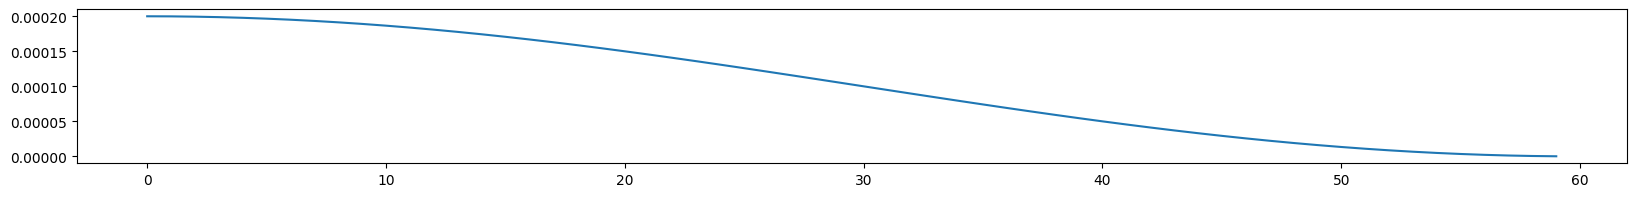

In [16]:
rcParams['figure.figsize'] = 20, 2
optimizer = optim.AdamW(m.parameters(), lr=init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs, eta_min=eta_min)

lrs = []
for epoch in range(1, n_epochs+1):
    scheduler_cosine.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
plt.plot(range(len(lrs)), lrs)



In [17]:
del m,optimizer
torch.cuda.empty_cache()
gc.collect()

45

# Training

In [18]:
from torch.utils.data import WeightedRandomSampler
def run(fold):

    log_file = os.path.join(log_dir, f'{kernel_type}.txt')
    model_file = os.path.join(model_dir, f'{kernel_type}_fold{fold}_best.pth')

    train_ = df[df['fold'] != fold].reset_index(drop=True)
    valid_ = df[df['fold'] == fold].reset_index(drop=True)
    dataset_train = CLSDataset(train_, 'train', transform=transforms_train)
    dataset_valid = CLSDataset(valid_, 'valid', transform=transforms_valid)
    

    class_counts = train_.label1.value_counts()
    print("class_counts",class_counts)
    #class_w=[1/c for c in class_counts]
    class_w=[1,2,4]
    sample_train_weights=[class_w[i] for i in train_.label1.values]
    sample_train_weights=[sample_train_weights[i]/train_.counts.values[i] for i in range(len(train_))]


    nsamp=3000
    sampler=WeightedRandomSampler(weights=sample_train_weights,num_samples=nsamp)

    
    #loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, num_workers=num_workers, drop_last=True,sampler=sampler)

    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = TimmModel(backbone, pretrained=True)
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=init_lr,weight_decay=1e-4)
    scaler = torch.cuda.amp.GradScaler() if use_amp else None

    metric_best = np.inf

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, n_epochs, eta_min=eta_min)

    print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, n_epochs+1):
        print(time.ctime(), 'Epoch:', epoch)
        train_loss = train_func(model, loader_train, optimizer, scaler)
        scheduler_cosine.step(epoch-1)   
        valid_loss = valid_func(model, loader_valid,valid_)
    
        metric = valid_loss

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, metric: {(metric):.6f}.'
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric < metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
#             if not DEBUG:
            torch.save(model.state_dict(), model_file)
            metric_best = metric

        # Save Last
        if not DEBUG:
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scaler_state_dict': scaler.state_dict() if scaler else None,
                    'score_best': metric_best,
                },
                model_file.replace('_best', '_last')
            )

    del model
    torch.cuda.empty_cache()
    gc.collect()

In [19]:
#run(0)
run(1)
run(2)
run(3)
run(4)

class_counts label1
0    10243
1      718
2      358
Name: count, dtype: int64
11319 2814
Sun Sep 10 16:13:02 2023 Epoch: 1


smth:0.8550: 100%|██████████| 938/938 [02:17<00:00,  6.84it/s]


Sun Sep 10 16:19:20 2023 Fold 1, Epoch 1, lr: 0.0002000, train loss: 0.73817, valid loss: 0.56831, metric: 0.568313.
metric_best (inf --> 0.568313). Saving model ...
Sun Sep 10 16:19:20 2023 Epoch: 2


smth:0.7877: 100%|██████████| 938/938 [02:14<00:00,  6.98it/s]


Sun Sep 10 16:25:33 2023 Fold 1, Epoch 2, lr: 0.0001999, train loss: 0.66353, valid loss: 0.53276, metric: 0.532761.
metric_best (0.568313 --> 0.532761). Saving model ...
Sun Sep 10 16:25:33 2023 Epoch: 3


smth:0.7435: 100%|██████████| 938/938 [02:10<00:00,  7.21it/s]


Sun Sep 10 16:31:44 2023 Fold 1, Epoch 3, lr: 0.0001995, train loss: 0.63800, valid loss: 0.52359, metric: 0.523591.
metric_best (0.532761 --> 0.523591). Saving model ...
Sun Sep 10 16:31:44 2023 Epoch: 4


smth:0.7229: 100%|██████████| 938/938 [02:10<00:00,  7.20it/s]


Sun Sep 10 16:37:53 2023 Fold 1, Epoch 4, lr: 0.0001988, train loss: 0.63604, valid loss: 0.51120, metric: 0.511200.
metric_best (0.523591 --> 0.511200). Saving model ...
Sun Sep 10 16:37:53 2023 Epoch: 5


smth:0.7555: 100%|██████████| 938/938 [02:16<00:00,  6.87it/s]


Sun Sep 10 16:44:12 2023 Fold 1, Epoch 5, lr: 0.0001978, train loss: 0.63055, valid loss: 0.54161, metric: 0.541614.
Sun Sep 10 16:44:12 2023 Epoch: 6


smth:0.7000: 100%|██████████| 938/938 [02:12<00:00,  7.08it/s]


Sun Sep 10 16:50:29 2023 Fold 1, Epoch 6, lr: 0.0001966, train loss: 0.60568, valid loss: 0.52718, metric: 0.527177.
Sun Sep 10 16:50:30 2023 Epoch: 7


smth:0.6877: 100%|██████████| 938/938 [02:13<00:00,  7.04it/s]


Sun Sep 10 16:56:47 2023 Fold 1, Epoch 7, lr: 0.0001951, train loss: 0.59066, valid loss: 0.47499, metric: 0.474990.
metric_best (0.511200 --> 0.474990). Saving model ...
Sun Sep 10 16:56:47 2023 Epoch: 8


smth:0.7539: 100%|██████████| 938/938 [02:14<00:00,  6.98it/s]


Sun Sep 10 17:03:09 2023 Fold 1, Epoch 8, lr: 0.0001934, train loss: 0.58347, valid loss: 0.45992, metric: 0.459922.
metric_best (0.474990 --> 0.459922). Saving model ...
Sun Sep 10 17:03:09 2023 Epoch: 9


smth:0.7253: 100%|██████████| 938/938 [02:16<00:00,  6.87it/s]


Sun Sep 10 17:09:32 2023 Fold 1, Epoch 9, lr: 0.0001914, train loss: 0.58632, valid loss: 0.53120, metric: 0.531202.
Sun Sep 10 17:09:32 2023 Epoch: 10


smth:0.6556: 100%|██████████| 938/938 [02:13<00:00,  7.01it/s]


Sun Sep 10 17:15:51 2023 Fold 1, Epoch 10, lr: 0.0001891, train loss: 0.55049, valid loss: 0.42926, metric: 0.429262.
metric_best (0.459922 --> 0.429262). Saving model ...
Sun Sep 10 17:15:52 2023 Epoch: 11


smth:0.6563: 100%|██████████| 938/938 [02:16<00:00,  6.87it/s]


Sun Sep 10 17:22:12 2023 Fold 1, Epoch 11, lr: 0.0001866, train loss: 0.55868, valid loss: 0.44998, metric: 0.449984.
Sun Sep 10 17:22:12 2023 Epoch: 12


smth:0.6551: 100%|██████████| 938/938 [02:15<00:00,  6.92it/s]


Sun Sep 10 17:28:31 2023 Fold 1, Epoch 12, lr: 0.0001839, train loss: 0.53992, valid loss: 0.42826, metric: 0.428262.
metric_best (0.429262 --> 0.428262). Saving model ...
Sun Sep 10 17:28:31 2023 Epoch: 13


smth:0.6768: 100%|██████████| 938/938 [02:08<00:00,  7.30it/s]


Sun Sep 10 17:34:42 2023 Fold 1, Epoch 13, lr: 0.0001809, train loss: 0.54827, valid loss: 0.43856, metric: 0.438562.
Sun Sep 10 17:34:42 2023 Epoch: 14


smth:0.6955: 100%|██████████| 938/938 [02:13<00:00,  7.03it/s]


Sun Sep 10 17:40:59 2023 Fold 1, Epoch 14, lr: 0.0001777, train loss: 0.51026, valid loss: 0.40183, metric: 0.401827.
metric_best (0.428262 --> 0.401827). Saving model ...
Sun Sep 10 17:41:00 2023 Epoch: 15


smth:0.7529: 100%|██████████| 938/938 [02:12<00:00,  7.10it/s]


Sun Sep 10 17:47:09 2023 Fold 1, Epoch 15, lr: 0.0001743, train loss: 0.53780, valid loss: 0.57250, metric: 0.572504.
Sun Sep 10 17:47:09 2023 Epoch: 16


smth:0.6551: 100%|██████████| 938/938 [02:10<00:00,  7.19it/s]


Sun Sep 10 17:53:22 2023 Fold 1, Epoch 16, lr: 0.0001707, train loss: 0.51529, valid loss: 0.40410, metric: 0.404097.
Sun Sep 10 17:53:22 2023 Epoch: 17


smth:0.5812: 100%|██████████| 938/938 [02:07<00:00,  7.36it/s]


Sun Sep 10 17:59:27 2023 Fold 1, Epoch 17, lr: 0.0001669, train loss: 0.48878, valid loss: 0.39171, metric: 0.391711.
metric_best (0.401827 --> 0.391711). Saving model ...
Sun Sep 10 17:59:30 2023 Epoch: 18


smth:0.6614: 100%|██████████| 938/938 [02:06<00:00,  7.39it/s]


Sun Sep 10 18:05:28 2023 Fold 1, Epoch 18, lr: 0.0001629, train loss: 0.49730, valid loss: 0.39459, metric: 0.394593.
Sun Sep 10 18:05:28 2023 Epoch: 19


smth:0.5998: 100%|██████████| 938/938 [02:24<00:00,  6.51it/s]


Sun Sep 10 18:11:58 2023 Fold 1, Epoch 19, lr: 0.0001588, train loss: 0.49109, valid loss: 0.39445, metric: 0.394450.
Sun Sep 10 18:11:59 2023 Epoch: 20


smth:0.6294: 100%|██████████| 938/938 [02:15<00:00,  6.91it/s]


Sun Sep 10 18:18:21 2023 Fold 1, Epoch 20, lr: 0.0001545, train loss: 0.48378, valid loss: 0.39082, metric: 0.390824.
metric_best (0.391711 --> 0.390824). Saving model ...
Sun Sep 10 18:18:21 2023 Epoch: 21


smth:0.6096: 100%|██████████| 938/938 [02:14<00:00,  6.98it/s]


Sun Sep 10 18:24:44 2023 Fold 1, Epoch 21, lr: 0.0001500, train loss: 0.46259, valid loss: 0.40192, metric: 0.401918.
Sun Sep 10 18:24:45 2023 Epoch: 22


smth:0.5231: 100%|██████████| 938/938 [02:14<00:00,  6.99it/s]


Sun Sep 10 18:31:04 2023 Fold 1, Epoch 22, lr: 0.0001454, train loss: 0.48865, valid loss: 0.37301, metric: 0.373012.
metric_best (0.390824 --> 0.373012). Saving model ...
Sun Sep 10 18:31:08 2023 Epoch: 23


smth:0.6078: 100%|██████████| 938/938 [02:10<00:00,  7.21it/s]


Sun Sep 10 18:37:21 2023 Fold 1, Epoch 23, lr: 0.0001407, train loss: 0.46986, valid loss: 0.37188, metric: 0.371880.
metric_best (0.373012 --> 0.371880). Saving model ...
Sun Sep 10 18:37:21 2023 Epoch: 24


smth:0.5845: 100%|██████████| 938/938 [02:10<00:00,  7.20it/s]


Sun Sep 10 18:43:30 2023 Fold 1, Epoch 24, lr: 0.0001358, train loss: 0.44055, valid loss: 0.37013, metric: 0.370133.
metric_best (0.371880 --> 0.370133). Saving model ...
Sun Sep 10 18:43:30 2023 Epoch: 25


smth:0.6138: 100%|██████████| 938/938 [02:09<00:00,  7.22it/s]


Sun Sep 10 18:49:38 2023 Fold 1, Epoch 25, lr: 0.0001309, train loss: 0.46250, valid loss: 0.37805, metric: 0.378054.
Sun Sep 10 18:49:38 2023 Epoch: 26


smth:0.5540: 100%|██████████| 938/938 [02:14<00:00,  6.95it/s]


Sun Sep 10 18:55:54 2023 Fold 1, Epoch 26, lr: 0.0001259, train loss: 0.46929, valid loss: 0.38221, metric: 0.382206.
Sun Sep 10 18:55:54 2023 Epoch: 27


smth:0.5574: 100%|██████████| 938/938 [02:21<00:00,  6.65it/s]


Sun Sep 10 19:02:23 2023 Fold 1, Epoch 27, lr: 0.0001208, train loss: 0.45226, valid loss: 0.38623, metric: 0.386229.
Sun Sep 10 19:02:24 2023 Epoch: 28


smth:0.6102: 100%|██████████| 938/938 [02:13<00:00,  7.03it/s]


Sun Sep 10 19:08:42 2023 Fold 1, Epoch 28, lr: 0.0001156, train loss: 0.45390, valid loss: 0.36961, metric: 0.369607.
metric_best (0.370133 --> 0.369607). Saving model ...
Sun Sep 10 19:08:42 2023 Epoch: 29


smth:0.6047: 100%|██████████| 938/938 [02:15<00:00,  6.92it/s]


Sun Sep 10 19:15:06 2023 Fold 1, Epoch 29, lr: 0.0001105, train loss: 0.44807, valid loss: 0.36631, metric: 0.366306.
metric_best (0.369607 --> 0.366306). Saving model ...
Sun Sep 10 19:15:06 2023 Epoch: 30


smth:0.5435: 100%|██████████| 938/938 [02:12<00:00,  7.08it/s]


Sun Sep 10 19:21:26 2023 Fold 1, Epoch 30, lr: 0.0001052, train loss: 0.45966, valid loss: 0.36060, metric: 0.360600.
metric_best (0.366306 --> 0.360600). Saving model ...
Sun Sep 10 19:21:26 2023 Epoch: 31


smth:0.6425: 100%|██████████| 938/938 [02:19<00:00,  6.71it/s]


Sun Sep 10 19:27:53 2023 Fold 1, Epoch 31, lr: 0.0001000, train loss: 0.42503, valid loss: 0.40135, metric: 0.401347.
Sun Sep 10 19:27:54 2023 Epoch: 32


smth:0.5573: 100%|██████████| 938/938 [02:10<00:00,  7.20it/s]


Sun Sep 10 19:34:05 2023 Fold 1, Epoch 32, lr: 0.0000948, train loss: 0.45248, valid loss: 0.40309, metric: 0.403091.
Sun Sep 10 19:34:06 2023 Epoch: 33


smth:0.5635: 100%|██████████| 938/938 [02:13<00:00,  7.00it/s]


Sun Sep 10 19:40:24 2023 Fold 1, Epoch 33, lr: 0.0000895, train loss: 0.44590, valid loss: 0.34362, metric: 0.343624.
metric_best (0.360600 --> 0.343624). Saving model ...
Sun Sep 10 19:40:28 2023 Epoch: 34


smth:0.6068: 100%|██████████| 938/938 [02:16<00:00,  6.89it/s]


Sun Sep 10 19:46:40 2023 Fold 1, Epoch 34, lr: 0.0000844, train loss: 0.43967, valid loss: 0.35514, metric: 0.355141.
Sun Sep 10 19:46:40 2023 Epoch: 35


smth:0.5713: 100%|██████████| 938/938 [02:12<00:00,  7.10it/s]


Sun Sep 10 19:52:53 2023 Fold 1, Epoch 35, lr: 0.0000792, train loss: 0.40480, valid loss: 0.39010, metric: 0.390104.
Sun Sep 10 19:52:53 2023 Epoch: 36


smth:0.5902: 100%|██████████| 938/938 [02:09<00:00,  7.23it/s]


Sun Sep 10 19:59:05 2023 Fold 1, Epoch 36, lr: 0.0000741, train loss: 0.40430, valid loss: 0.39986, metric: 0.399862.
Sun Sep 10 19:59:05 2023 Epoch: 37


smth:0.5461: 100%|██████████| 938/938 [02:15<00:00,  6.90it/s]


Sun Sep 10 20:05:21 2023 Fold 1, Epoch 37, lr: 0.0000691, train loss: 0.42000, valid loss: 0.37173, metric: 0.371727.
Sun Sep 10 20:05:21 2023 Epoch: 38


smth:0.5614: 100%|██████████| 938/938 [02:16<00:00,  6.87it/s]


Sun Sep 10 20:11:48 2023 Fold 1, Epoch 38, lr: 0.0000642, train loss: 0.41090, valid loss: 0.39198, metric: 0.391984.
Sun Sep 10 20:11:48 2023 Epoch: 39


smth:0.5443: 100%|██████████| 938/938 [02:09<00:00,  7.27it/s]


Sun Sep 10 20:17:52 2023 Fold 1, Epoch 39, lr: 0.0000593, train loss: 0.39459, valid loss: 0.37951, metric: 0.379508.
Sun Sep 10 20:17:53 2023 Epoch: 40


smth:0.5471: 100%|██████████| 938/938 [02:09<00:00,  7.23it/s]


Sun Sep 10 20:24:11 2023 Fold 1, Epoch 40, lr: 0.0000546, train loss: 0.40673, valid loss: 0.38135, metric: 0.381348.
Sun Sep 10 20:24:11 2023 Epoch: 41


smth:0.5180: 100%|██████████| 938/938 [02:08<00:00,  7.29it/s]


Sun Sep 10 20:30:15 2023 Fold 1, Epoch 41, lr: 0.0000500, train loss: 0.38473, valid loss: 0.37012, metric: 0.370120.
Sun Sep 10 20:30:15 2023 Epoch: 42


smth:0.5170: 100%|██████████| 938/938 [02:07<00:00,  7.38it/s]


Sun Sep 10 20:36:18 2023 Fold 1, Epoch 42, lr: 0.0000455, train loss: 0.37649, valid loss: 0.32909, metric: 0.329089.
metric_best (0.343624 --> 0.329089). Saving model ...
Sun Sep 10 20:36:18 2023 Epoch: 43


smth:0.5205: 100%|██████████| 938/938 [02:10<00:00,  7.18it/s]


Sun Sep 10 20:42:30 2023 Fold 1, Epoch 43, lr: 0.0000412, train loss: 0.41101, valid loss: 0.36537, metric: 0.365374.
Sun Sep 10 20:42:30 2023 Epoch: 44


smth:0.4973: 100%|██████████| 938/938 [02:13<00:00,  7.03it/s]


Sun Sep 10 20:48:40 2023 Fold 1, Epoch 44, lr: 0.0000371, train loss: 0.38658, valid loss: 0.34707, metric: 0.347067.
Sun Sep 10 20:48:40 2023 Epoch: 45


smth:0.4917: 100%|██████████| 938/938 [02:07<00:00,  7.35it/s]


Sun Sep 10 20:54:45 2023 Fold 1, Epoch 45, lr: 0.0000331, train loss: 0.39947, valid loss: 0.34206, metric: 0.342055.
Sun Sep 10 20:54:45 2023 Epoch: 46


smth:0.5208: 100%|██████████| 938/938 [02:13<00:00,  7.05it/s]


Sun Sep 10 21:00:59 2023 Fold 1, Epoch 46, lr: 0.0000293, train loss: 0.38360, valid loss: 0.39274, metric: 0.392745.
Sun Sep 10 21:01:00 2023 Epoch: 47


smth:0.4934: 100%|██████████| 938/938 [02:13<00:00,  7.04it/s]


Sun Sep 10 21:07:18 2023 Fold 1, Epoch 47, lr: 0.0000257, train loss: 0.39357, valid loss: 0.36491, metric: 0.364914.
Sun Sep 10 21:07:18 2023 Epoch: 48


smth:0.5063: 100%|██████████| 938/938 [02:10<00:00,  7.17it/s]


Sun Sep 10 21:13:34 2023 Fold 1, Epoch 48, lr: 0.0000223, train loss: 0.39944, valid loss: 0.36410, metric: 0.364097.
Sun Sep 10 21:13:34 2023 Epoch: 49


smth:0.5255: 100%|██████████| 938/938 [02:12<00:00,  7.07it/s]


Sun Sep 10 21:19:41 2023 Fold 1, Epoch 49, lr: 0.0000191, train loss: 0.35913, valid loss: 0.35451, metric: 0.354511.
Sun Sep 10 21:19:42 2023 Epoch: 50


smth:0.5217: 100%|██████████| 938/938 [02:09<00:00,  7.23it/s]


Sun Sep 10 21:25:46 2023 Fold 1, Epoch 50, lr: 0.0000161, train loss: 0.35788, valid loss: 0.34379, metric: 0.343790.
Sun Sep 10 21:25:46 2023 Epoch: 51


smth:0.5441: 100%|██████████| 938/938 [02:09<00:00,  7.22it/s]


Sun Sep 10 21:31:54 2023 Fold 1, Epoch 51, lr: 0.0000134, train loss: 0.41559, valid loss: 0.35893, metric: 0.358933.
Sun Sep 10 21:31:54 2023 Epoch: 52


smth:0.5372: 100%|██████████| 938/938 [02:11<00:00,  7.12it/s]


Sun Sep 10 21:38:02 2023 Fold 1, Epoch 52, lr: 0.0000109, train loss: 0.37604, valid loss: 0.35579, metric: 0.355786.
Sun Sep 10 21:38:03 2023 Epoch: 53


smth:0.5144: 100%|██████████| 938/938 [02:13<00:00,  7.04it/s]


Sun Sep 10 21:44:22 2023 Fold 1, Epoch 53, lr: 0.0000086, train loss: 0.37329, valid loss: 0.35701, metric: 0.357014.
Sun Sep 10 21:44:22 2023 Epoch: 54


smth:0.5089: 100%|██████████| 938/938 [02:15<00:00,  6.90it/s]


Sun Sep 10 21:50:40 2023 Fold 1, Epoch 54, lr: 0.0000066, train loss: 0.37787, valid loss: 0.34953, metric: 0.349534.
Sun Sep 10 21:50:40 2023 Epoch: 55


smth:0.5171: 100%|██████████| 938/938 [02:09<00:00,  7.26it/s]


Sun Sep 10 21:56:49 2023 Fold 1, Epoch 55, lr: 0.0000049, train loss: 0.36794, valid loss: 0.34803, metric: 0.348031.
Sun Sep 10 21:56:49 2023 Epoch: 56


smth:0.5257: 100%|██████████| 938/938 [02:09<00:00,  7.26it/s]


Sun Sep 10 22:02:55 2023 Fold 1, Epoch 56, lr: 0.0000034, train loss: 0.37650, valid loss: 0.36143, metric: 0.361425.
Sun Sep 10 22:02:56 2023 Epoch: 57


smth:0.5209: 100%|██████████| 938/938 [02:09<00:00,  7.24it/s]


Sun Sep 10 22:09:03 2023 Fold 1, Epoch 57, lr: 0.0000022, train loss: 0.36788, valid loss: 0.36512, metric: 0.365119.
Sun Sep 10 22:09:03 2023 Epoch: 58


smth:0.5232: 100%|██████████| 938/938 [02:13<00:00,  7.02it/s]


Sun Sep 10 22:15:14 2023 Fold 1, Epoch 58, lr: 0.0000012, train loss: 0.39902, valid loss: 0.36512, metric: 0.365123.
Sun Sep 10 22:15:14 2023 Epoch: 59


smth:0.4844: 100%|██████████| 938/938 [02:12<00:00,  7.06it/s]


Sun Sep 10 22:21:32 2023 Fold 1, Epoch 59, lr: 0.0000005, train loss: 0.34777, valid loss: 0.33757, metric: 0.337573.
Sun Sep 10 22:21:32 2023 Epoch: 60


smth:0.5223: 100%|██████████| 938/938 [02:17<00:00,  6.82it/s]


Sun Sep 10 22:27:52 2023 Fold 1, Epoch 60, lr: 0.0000001, train loss: 0.38587, valid loss: 0.36044, metric: 0.360442.
class_counts label1
0    10353
1      684
2      321
Name: count, dtype: int64
11358 2775
Sun Sep 10 22:27:53 2023 Epoch: 1


smth:0.6835: 100%|██████████| 925/925 [02:13<00:00,  6.92it/s]


Sun Sep 10 22:34:10 2023 Fold 2, Epoch 1, lr: 0.0002000, train loss: 0.75510, valid loss: 0.63192, metric: 0.631921.
metric_best (inf --> 0.631921). Saving model ...
Sun Sep 10 22:34:10 2023 Epoch: 2


smth:0.6367: 100%|██████████| 925/925 [02:13<00:00,  6.94it/s]


Sun Sep 10 22:40:29 2023 Fold 2, Epoch 2, lr: 0.0001999, train loss: 0.63506, valid loss: 0.63533, metric: 0.635327.
Sun Sep 10 22:40:30 2023 Epoch: 3


smth:0.6441: 100%|██████████| 925/925 [02:14<00:00,  6.87it/s]


Sun Sep 10 22:46:54 2023 Fold 2, Epoch 3, lr: 0.0001995, train loss: 0.61914, valid loss: 0.62228, metric: 0.622277.
metric_best (0.631921 --> 0.622277). Saving model ...
Sun Sep 10 22:46:55 2023 Epoch: 4


smth:0.5940: 100%|██████████| 925/925 [02:13<00:00,  6.95it/s]


Sun Sep 10 22:53:14 2023 Fold 2, Epoch 4, lr: 0.0001988, train loss: 0.61279, valid loss: 0.56111, metric: 0.561106.
metric_best (0.622277 --> 0.561106). Saving model ...
Sun Sep 10 22:53:15 2023 Epoch: 5


smth:0.6321: 100%|██████████| 925/925 [02:13<00:00,  6.95it/s]


Sun Sep 10 22:59:36 2023 Fold 2, Epoch 5, lr: 0.0001978, train loss: 0.64168, valid loss: 0.58894, metric: 0.588944.
Sun Sep 10 22:59:36 2023 Epoch: 6


smth:0.5897: 100%|██████████| 925/925 [02:15<00:00,  6.83it/s]


Sun Sep 10 23:05:57 2023 Fold 2, Epoch 6, lr: 0.0001966, train loss: 0.59252, valid loss: 0.57828, metric: 0.578282.
Sun Sep 10 23:05:57 2023 Epoch: 7


smth:0.5892: 100%|██████████| 925/925 [02:09<00:00,  7.12it/s]


Sun Sep 10 23:12:04 2023 Fold 2, Epoch 7, lr: 0.0001951, train loss: 0.60369, valid loss: 0.56562, metric: 0.565620.
Sun Sep 10 23:12:04 2023 Epoch: 8


smth:0.5951: 100%|██████████| 925/925 [02:10<00:00,  7.11it/s]


Sun Sep 10 23:18:11 2023 Fold 2, Epoch 8, lr: 0.0001934, train loss: 0.57887, valid loss: 0.54521, metric: 0.545206.
metric_best (0.561106 --> 0.545206). Saving model ...
Sun Sep 10 23:18:12 2023 Epoch: 9


smth:0.5168: 100%|██████████| 925/925 [02:09<00:00,  7.15it/s]


Sun Sep 10 23:24:18 2023 Fold 2, Epoch 9, lr: 0.0001914, train loss: 0.58114, valid loss: 0.50962, metric: 0.509617.
metric_best (0.545206 --> 0.509617). Saving model ...
Sun Sep 10 23:24:18 2023 Epoch: 10


smth:0.5170: 100%|██████████| 925/925 [02:09<00:00,  7.17it/s]


Sun Sep 10 23:30:24 2023 Fold 2, Epoch 10, lr: 0.0001891, train loss: 0.57734, valid loss: 0.56253, metric: 0.562527.
Sun Sep 10 23:30:25 2023 Epoch: 11


smth:0.5891: 100%|██████████| 925/925 [02:09<00:00,  7.15it/s]


Sun Sep 10 23:36:31 2023 Fold 2, Epoch 11, lr: 0.0001866, train loss: 0.57775, valid loss: 0.53137, metric: 0.531372.
Sun Sep 10 23:36:32 2023 Epoch: 12


smth:0.5143: 100%|██████████| 925/925 [02:08<00:00,  7.19it/s]


Sun Sep 10 23:42:36 2023 Fold 2, Epoch 12, lr: 0.0001839, train loss: 0.54640, valid loss: 0.51180, metric: 0.511798.
Sun Sep 10 23:42:37 2023 Epoch: 13


smth:0.5273: 100%|██████████| 925/925 [02:09<00:00,  7.17it/s]


Sun Sep 10 23:48:43 2023 Fold 2, Epoch 13, lr: 0.0001809, train loss: 0.52829, valid loss: 0.50536, metric: 0.505364.
metric_best (0.509617 --> 0.505364). Saving model ...
Sun Sep 10 23:48:44 2023 Epoch: 14


smth:0.5523: 100%|██████████| 925/925 [02:09<00:00,  7.16it/s]


Sun Sep 10 23:54:51 2023 Fold 2, Epoch 14, lr: 0.0001777, train loss: 0.52752, valid loss: 0.55318, metric: 0.553183.
Sun Sep 10 23:54:51 2023 Epoch: 15


smth:0.5100: 100%|██████████| 925/925 [02:09<00:00,  7.16it/s]


Mon Sep 11 00:00:57 2023 Fold 2, Epoch 15, lr: 0.0001743, train loss: 0.52102, valid loss: 0.50700, metric: 0.507000.
Mon Sep 11 00:00:58 2023 Epoch: 16


smth:0.4624: 100%|██████████| 925/925 [02:08<00:00,  7.19it/s]


Mon Sep 11 00:07:05 2023 Fold 2, Epoch 16, lr: 0.0001707, train loss: 0.53883, valid loss: 0.48556, metric: 0.485565.
metric_best (0.505364 --> 0.485565). Saving model ...
Mon Sep 11 00:07:05 2023 Epoch: 17


smth:0.5218: 100%|██████████| 925/925 [02:16<00:00,  6.78it/s]


Mon Sep 11 00:13:19 2023 Fold 2, Epoch 17, lr: 0.0001669, train loss: 0.49502, valid loss: 0.45669, metric: 0.456694.
metric_best (0.485565 --> 0.456694). Saving model ...
Mon Sep 11 00:13:30 2023 Epoch: 18


smth:0.5601: 100%|██████████| 925/925 [02:09<00:00,  7.15it/s]


Mon Sep 11 00:19:36 2023 Fold 2, Epoch 18, lr: 0.0001629, train loss: 0.54274, valid loss: 0.52551, metric: 0.525509.
Mon Sep 11 00:19:36 2023 Epoch: 19


smth:0.4680: 100%|██████████| 925/925 [02:08<00:00,  7.17it/s]


Mon Sep 11 00:25:44 2023 Fold 2, Epoch 19, lr: 0.0001588, train loss: 0.47568, valid loss: 0.46992, metric: 0.469919.
Mon Sep 11 00:25:45 2023 Epoch: 20


smth:0.4308: 100%|██████████| 925/925 [02:09<00:00,  7.15it/s]


Mon Sep 11 00:31:52 2023 Fold 2, Epoch 20, lr: 0.0001545, train loss: 0.47751, valid loss: 0.45177, metric: 0.451768.
metric_best (0.456694 --> 0.451768). Saving model ...
Mon Sep 11 00:31:53 2023 Epoch: 21


smth:0.5522: 100%|██████████| 925/925 [02:08<00:00,  7.18it/s]


Mon Sep 11 00:37:59 2023 Fold 2, Epoch 21, lr: 0.0001500, train loss: 0.48698, valid loss: 0.47685, metric: 0.476853.
Mon Sep 11 00:38:00 2023 Epoch: 22


smth:0.4214: 100%|██████████| 925/925 [02:09<00:00,  7.14it/s]


Mon Sep 11 00:44:08 2023 Fold 2, Epoch 22, lr: 0.0001454, train loss: 0.46399, valid loss: 0.44346, metric: 0.443457.
metric_best (0.451768 --> 0.443457). Saving model ...
Mon Sep 11 00:44:08 2023 Epoch: 23


smth:0.4542: 100%|██████████| 925/925 [02:09<00:00,  7.16it/s]


Mon Sep 11 00:50:13 2023 Fold 2, Epoch 23, lr: 0.0001407, train loss: 0.47201, valid loss: 0.46376, metric: 0.463757.
Mon Sep 11 00:50:15 2023 Epoch: 24


smth:0.4599: 100%|██████████| 925/925 [02:08<00:00,  7.18it/s]


Mon Sep 11 00:56:19 2023 Fold 2, Epoch 24, lr: 0.0001358, train loss: 0.50443, valid loss: 0.47433, metric: 0.474330.
Mon Sep 11 00:56:20 2023 Epoch: 25


smth:0.5549: 100%|██████████| 925/925 [02:08<00:00,  7.17it/s]


Mon Sep 11 01:02:26 2023 Fold 2, Epoch 25, lr: 0.0001309, train loss: 0.45457, valid loss: 0.51170, metric: 0.511701.
Mon Sep 11 01:02:26 2023 Epoch: 26


smth:0.5405: 100%|██████████| 925/925 [02:09<00:00,  7.16it/s]


Mon Sep 11 01:08:34 2023 Fold 2, Epoch 26, lr: 0.0001259, train loss: 0.46201, valid loss: 0.44829, metric: 0.448288.
Mon Sep 11 01:08:34 2023 Epoch: 27


smth:0.4879: 100%|██████████| 925/925 [02:08<00:00,  7.19it/s]


Mon Sep 11 01:14:41 2023 Fold 2, Epoch 27, lr: 0.0001208, train loss: 0.48311, valid loss: 0.43637, metric: 0.436366.
metric_best (0.443457 --> 0.436366). Saving model ...
Mon Sep 11 01:14:41 2023 Epoch: 28


smth:0.4939: 100%|██████████| 925/925 [02:09<00:00,  7.12it/s]


Mon Sep 11 01:20:48 2023 Fold 2, Epoch 28, lr: 0.0001156, train loss: 0.44609, valid loss: 0.44540, metric: 0.445401.
Mon Sep 11 01:20:48 2023 Epoch: 29


smth:0.5006: 100%|██████████| 925/925 [02:08<00:00,  7.18it/s]


Mon Sep 11 01:26:53 2023 Fold 2, Epoch 29, lr: 0.0001105, train loss: 0.44914, valid loss: 0.45731, metric: 0.457312.
Mon Sep 11 01:26:54 2023 Epoch: 30


smth:0.4371: 100%|██████████| 925/925 [02:09<00:00,  7.17it/s]


Mon Sep 11 01:33:01 2023 Fold 2, Epoch 30, lr: 0.0001052, train loss: 0.47369, valid loss: 0.40721, metric: 0.407209.
metric_best (0.436366 --> 0.407209). Saving model ...
Mon Sep 11 01:33:02 2023 Epoch: 31


smth:0.3982: 100%|██████████| 925/925 [02:09<00:00,  7.16it/s]


Mon Sep 11 01:39:10 2023 Fold 2, Epoch 31, lr: 0.0001000, train loss: 0.44216, valid loss: 0.42892, metric: 0.428918.
Mon Sep 11 01:39:10 2023 Epoch: 32


smth:0.4402: 100%|██████████| 925/925 [02:08<00:00,  7.18it/s]


Mon Sep 11 01:45:16 2023 Fold 2, Epoch 32, lr: 0.0000948, train loss: 0.43325, valid loss: 0.42969, metric: 0.429687.
Mon Sep 11 01:45:16 2023 Epoch: 33


smth:0.4253: 100%|██████████| 925/925 [02:11<00:00,  7.06it/s]


Mon Sep 11 01:51:23 2023 Fold 2, Epoch 33, lr: 0.0000895, train loss: 0.46381, valid loss: 0.42585, metric: 0.425854.
Mon Sep 11 01:51:24 2023 Epoch: 34


smth:0.4099: 100%|██████████| 925/925 [02:09<00:00,  7.16it/s]


Mon Sep 11 01:57:29 2023 Fold 2, Epoch 34, lr: 0.0000844, train loss: 0.41875, valid loss: 0.42550, metric: 0.425498.
Mon Sep 11 01:57:29 2023 Epoch: 35


smth:0.3780: 100%|██████████| 925/925 [02:08<00:00,  7.20it/s]


Mon Sep 11 02:03:36 2023 Fold 2, Epoch 35, lr: 0.0000792, train loss: 0.41005, valid loss: 0.41425, metric: 0.414253.
Mon Sep 11 02:03:36 2023 Epoch: 36


smth:0.3309: 100%|██████████| 925/925 [02:08<00:00,  7.19it/s]


Mon Sep 11 02:09:44 2023 Fold 2, Epoch 36, lr: 0.0000741, train loss: 0.42993, valid loss: 0.40857, metric: 0.408567.
Mon Sep 11 02:09:44 2023 Epoch: 37


smth:0.3276: 100%|██████████| 925/925 [02:09<00:00,  7.16it/s]


Mon Sep 11 02:15:51 2023 Fold 2, Epoch 37, lr: 0.0000691, train loss: 0.42528, valid loss: 0.40331, metric: 0.403308.
metric_best (0.407209 --> 0.403308). Saving model ...
Mon Sep 11 02:15:52 2023 Epoch: 38


smth:0.4186: 100%|██████████| 925/925 [02:08<00:00,  7.20it/s]


Mon Sep 11 02:21:57 2023 Fold 2, Epoch 38, lr: 0.0000642, train loss: 0.43281, valid loss: 0.42842, metric: 0.428420.
Mon Sep 11 02:21:59 2023 Epoch: 39


smth:0.3726: 100%|██████████| 925/925 [02:09<00:00,  7.16it/s]


Mon Sep 11 02:28:04 2023 Fold 2, Epoch 39, lr: 0.0000593, train loss: 0.39685, valid loss: 0.40711, metric: 0.407107.
Mon Sep 11 02:28:05 2023 Epoch: 40


smth:0.3583: 100%|██████████| 925/925 [02:09<00:00,  7.16it/s]


Mon Sep 11 02:34:13 2023 Fold 2, Epoch 40, lr: 0.0000546, train loss: 0.43292, valid loss: 0.41094, metric: 0.410939.
Mon Sep 11 02:34:13 2023 Epoch: 41


smth:0.3487: 100%|██████████| 925/925 [02:08<00:00,  7.19it/s]


Mon Sep 11 02:40:20 2023 Fold 2, Epoch 41, lr: 0.0000500, train loss: 0.39822, valid loss: 0.38841, metric: 0.388414.
metric_best (0.403308 --> 0.388414). Saving model ...
Mon Sep 11 02:40:20 2023 Epoch: 42


smth:0.3911: 100%|██████████| 925/925 [02:09<00:00,  7.15it/s]


Mon Sep 11 02:46:26 2023 Fold 2, Epoch 42, lr: 0.0000455, train loss: 0.39424, valid loss: 0.40989, metric: 0.409893.
Mon Sep 11 02:46:26 2023 Epoch: 43


smth:0.3933: 100%|██████████| 925/925 [02:08<00:00,  7.19it/s]


Mon Sep 11 02:52:31 2023 Fold 2, Epoch 43, lr: 0.0000412, train loss: 0.41394, valid loss: 0.40721, metric: 0.407211.
Mon Sep 11 02:52:31 2023 Epoch: 44


smth:0.4394: 100%|██████████| 925/925 [02:10<00:00,  7.08it/s]


Mon Sep 11 02:58:38 2023 Fold 2, Epoch 44, lr: 0.0000371, train loss: 0.39621, valid loss: 0.42221, metric: 0.422215.
Mon Sep 11 02:58:39 2023 Epoch: 45


smth:0.4468: 100%|██████████| 925/925 [02:09<00:00,  7.16it/s]


Mon Sep 11 03:04:45 2023 Fold 2, Epoch 45, lr: 0.0000331, train loss: 0.37889, valid loss: 0.44957, metric: 0.449565.
Mon Sep 11 03:04:46 2023 Epoch: 46


smth:0.4361: 100%|██████████| 925/925 [02:09<00:00,  7.16it/s]


Mon Sep 11 03:10:51 2023 Fold 2, Epoch 46, lr: 0.0000293, train loss: 0.37865, valid loss: 0.43220, metric: 0.432202.
Mon Sep 11 03:10:52 2023 Epoch: 47


smth:0.4130: 100%|██████████| 925/925 [02:09<00:00,  7.16it/s]


Mon Sep 11 03:16:58 2023 Fold 2, Epoch 47, lr: 0.0000257, train loss: 0.39586, valid loss: 0.41018, metric: 0.410183.
Mon Sep 11 03:16:58 2023 Epoch: 48


smth:0.4359: 100%|██████████| 925/925 [02:10<00:00,  7.11it/s]


Mon Sep 11 03:23:05 2023 Fold 2, Epoch 48, lr: 0.0000223, train loss: 0.37227, valid loss: 0.40802, metric: 0.408020.
Mon Sep 11 03:23:06 2023 Epoch: 49


smth:0.3879: 100%|██████████| 925/925 [02:08<00:00,  7.17it/s]


Mon Sep 11 03:29:11 2023 Fold 2, Epoch 49, lr: 0.0000191, train loss: 0.40794, valid loss: 0.39473, metric: 0.394733.
Mon Sep 11 03:29:13 2023 Epoch: 50


smth:0.3825: 100%|██████████| 925/925 [02:09<00:00,  7.17it/s]


Mon Sep 11 03:35:18 2023 Fold 2, Epoch 50, lr: 0.0000161, train loss: 0.35408, valid loss: 0.38977, metric: 0.389771.
Mon Sep 11 03:35:18 2023 Epoch: 51


smth:0.4103: 100%|██████████| 925/925 [02:09<00:00,  7.17it/s]


Mon Sep 11 03:41:25 2023 Fold 2, Epoch 51, lr: 0.0000134, train loss: 0.36905, valid loss: 0.38690, metric: 0.386903.
metric_best (0.388414 --> 0.386903). Saving model ...
Mon Sep 11 03:41:25 2023 Epoch: 52


smth:0.4713: 100%|██████████| 925/925 [02:09<00:00,  7.17it/s]


Mon Sep 11 03:47:32 2023 Fold 2, Epoch 52, lr: 0.0000109, train loss: 0.38066, valid loss: 0.43902, metric: 0.439024.
Mon Sep 11 03:47:32 2023 Epoch: 53


smth:0.3848: 100%|██████████| 925/925 [02:09<00:00,  7.14it/s]


Mon Sep 11 03:53:39 2023 Fold 2, Epoch 53, lr: 0.0000086, train loss: 0.36921, valid loss: 0.38406, metric: 0.384058.
metric_best (0.386903 --> 0.384058). Saving model ...
Mon Sep 11 03:53:40 2023 Epoch: 54


smth:0.4371: 100%|██████████| 925/925 [02:10<00:00,  7.10it/s]


Mon Sep 11 03:59:46 2023 Fold 2, Epoch 54, lr: 0.0000066, train loss: 0.40705, valid loss: 0.39387, metric: 0.393871.
Mon Sep 11 03:59:46 2023 Epoch: 55


smth:0.4801: 100%|██████████| 925/925 [02:09<00:00,  7.15it/s]


Mon Sep 11 04:05:52 2023 Fold 2, Epoch 55, lr: 0.0000049, train loss: 0.38633, valid loss: 0.43046, metric: 0.430463.
Mon Sep 11 04:05:52 2023 Epoch: 56


smth:0.4296: 100%|██████████| 925/925 [02:09<00:00,  7.16it/s]


Mon Sep 11 04:11:59 2023 Fold 2, Epoch 56, lr: 0.0000034, train loss: 0.34581, valid loss: 0.39927, metric: 0.399272.
Mon Sep 11 04:11:59 2023 Epoch: 57


smth:0.4249: 100%|██████████| 925/925 [02:09<00:00,  7.15it/s]


Mon Sep 11 04:18:06 2023 Fold 2, Epoch 57, lr: 0.0000022, train loss: 0.36465, valid loss: 0.39941, metric: 0.399412.
Mon Sep 11 04:18:06 2023 Epoch: 58


smth:0.4514: 100%|██████████| 925/925 [02:09<00:00,  7.15it/s]


Mon Sep 11 04:24:13 2023 Fold 2, Epoch 58, lr: 0.0000012, train loss: 0.37719, valid loss: 0.41972, metric: 0.419721.
Mon Sep 11 04:24:13 2023 Epoch: 59


smth:0.4127: 100%|██████████| 925/925 [02:10<00:00,  7.07it/s]


Mon Sep 11 04:30:20 2023 Fold 2, Epoch 59, lr: 0.0000005, train loss: 0.39097, valid loss: 0.39677, metric: 0.396774.
Mon Sep 11 04:30:20 2023 Epoch: 60


smth:0.4251: 100%|██████████| 925/925 [02:09<00:00,  7.15it/s]


Mon Sep 11 04:36:25 2023 Fold 2, Epoch 60, lr: 0.0000001, train loss: 0.37225, valid loss: 0.39884, metric: 0.398845.
class_counts label1
0    10239
1      701
2      370
Name: count, dtype: int64
11310 2823
Mon Sep 11 04:36:28 2023 Epoch: 1


smth:0.4333: 100%|██████████| 941/941 [02:11<00:00,  7.13it/s]


Mon Sep 11 04:42:36 2023 Fold 3, Epoch 1, lr: 0.0002000, train loss: 0.73942, valid loss: 0.57464, metric: 0.574642.
metric_best (inf --> 0.574642). Saving model ...
Mon Sep 11 04:42:36 2023 Epoch: 2


smth:0.4317: 100%|██████████| 941/941 [02:09<00:00,  7.29it/s]


Mon Sep 11 04:48:43 2023 Fold 3, Epoch 2, lr: 0.0001999, train loss: 0.66372, valid loss: 0.52887, metric: 0.528874.
metric_best (0.574642 --> 0.528874). Saving model ...
Mon Sep 11 04:48:43 2023 Epoch: 3


smth:0.4908: 100%|██████████| 941/941 [02:08<00:00,  7.33it/s]


Mon Sep 11 04:54:50 2023 Fold 3, Epoch 3, lr: 0.0001995, train loss: 0.63341, valid loss: 0.53029, metric: 0.530293.
Mon Sep 11 04:54:51 2023 Epoch: 4


smth:0.4918: 100%|██████████| 941/941 [02:10<00:00,  7.24it/s]


Mon Sep 11 05:00:59 2023 Fold 3, Epoch 4, lr: 0.0001988, train loss: 0.65327, valid loss: 0.50941, metric: 0.509411.
metric_best (0.528874 --> 0.509411). Saving model ...
Mon Sep 11 05:00:59 2023 Epoch: 5


smth:0.4506: 100%|██████████| 941/941 [02:09<00:00,  7.28it/s]


Mon Sep 11 05:07:07 2023 Fold 3, Epoch 5, lr: 0.0001978, train loss: 0.61325, valid loss: 0.48804, metric: 0.488036.
metric_best (0.509411 --> 0.488036). Saving model ...
Mon Sep 11 05:07:07 2023 Epoch: 6


smth:0.3911: 100%|██████████| 941/941 [02:12<00:00,  7.12it/s]


Mon Sep 11 05:13:15 2023 Fold 3, Epoch 6, lr: 0.0001966, train loss: 0.60204, valid loss: 0.48132, metric: 0.481317.
metric_best (0.488036 --> 0.481317). Saving model ...
Mon Sep 11 05:13:16 2023 Epoch: 7


smth:0.4379: 100%|██████████| 941/941 [02:09<00:00,  7.24it/s]


Mon Sep 11 05:19:22 2023 Fold 3, Epoch 7, lr: 0.0001951, train loss: 0.58801, valid loss: 0.44275, metric: 0.442746.
metric_best (0.481317 --> 0.442746). Saving model ...
Mon Sep 11 05:19:22 2023 Epoch: 8


smth:0.4833: 100%|██████████| 941/941 [02:09<00:00,  7.26it/s]


Mon Sep 11 05:25:31 2023 Fold 3, Epoch 8, lr: 0.0001934, train loss: 0.60005, valid loss: 0.47534, metric: 0.475344.
Mon Sep 11 05:25:31 2023 Epoch: 9


smth:0.5290: 100%|██████████| 941/941 [02:13<00:00,  7.05it/s]


Mon Sep 11 05:31:49 2023 Fold 3, Epoch 9, lr: 0.0001914, train loss: 0.56351, valid loss: 0.46874, metric: 0.468737.
Mon Sep 11 05:31:50 2023 Epoch: 10


smth:0.4784: 100%|██████████| 941/941 [02:14<00:00,  7.02it/s]


Mon Sep 11 05:38:10 2023 Fold 3, Epoch 10, lr: 0.0001891, train loss: 0.57047, valid loss: 0.44909, metric: 0.449094.
Mon Sep 11 05:38:11 2023 Epoch: 11


smth:0.3898: 100%|██████████| 941/941 [02:13<00:00,  7.04it/s]


Mon Sep 11 05:44:32 2023 Fold 3, Epoch 11, lr: 0.0001866, train loss: 0.56022, valid loss: 0.49308, metric: 0.493084.
Mon Sep 11 05:44:33 2023 Epoch: 12


smth:0.5721: 100%|██████████| 941/941 [02:14<00:00,  7.00it/s]


Mon Sep 11 05:50:53 2023 Fold 3, Epoch 12, lr: 0.0001839, train loss: 0.54547, valid loss: 0.57147, metric: 0.571471.
Mon Sep 11 05:50:53 2023 Epoch: 13


smth:0.4935: 100%|██████████| 941/941 [02:14<00:00,  7.02it/s]


Mon Sep 11 05:57:14 2023 Fold 3, Epoch 13, lr: 0.0001809, train loss: 0.51227, valid loss: 0.42683, metric: 0.426829.
metric_best (0.442746 --> 0.426829). Saving model ...
Mon Sep 11 05:57:15 2023 Epoch: 14


smth:0.3805: 100%|██████████| 941/941 [02:14<00:00,  7.01it/s]


Mon Sep 11 06:03:36 2023 Fold 3, Epoch 14, lr: 0.0001777, train loss: 0.56347, valid loss: 0.43693, metric: 0.436926.
Mon Sep 11 06:03:36 2023 Epoch: 15


smth:0.4279: 100%|██████████| 941/941 [02:13<00:00,  7.04it/s]


Mon Sep 11 06:09:57 2023 Fold 3, Epoch 15, lr: 0.0001743, train loss: 0.53915, valid loss: 0.46630, metric: 0.466300.
Mon Sep 11 06:09:57 2023 Epoch: 16


smth:0.4288: 100%|██████████| 941/941 [02:14<00:00,  7.01it/s]


Mon Sep 11 06:16:19 2023 Fold 3, Epoch 16, lr: 0.0001707, train loss: 0.54227, valid loss: 0.48448, metric: 0.484481.
Mon Sep 11 06:16:19 2023 Epoch: 17


smth:0.3926: 100%|██████████| 941/941 [02:15<00:00,  6.95it/s]


Mon Sep 11 06:22:40 2023 Fold 3, Epoch 17, lr: 0.0001669, train loss: 0.48665, valid loss: 0.42972, metric: 0.429719.
Mon Sep 11 06:22:40 2023 Epoch: 18


smth:0.4918: 100%|██████████| 941/941 [02:14<00:00,  7.02it/s]


Mon Sep 11 06:29:00 2023 Fold 3, Epoch 18, lr: 0.0001629, train loss: 0.50533, valid loss: 0.41409, metric: 0.414092.
metric_best (0.426829 --> 0.414092). Saving model ...
Mon Sep 11 06:29:00 2023 Epoch: 19


smth:0.4183: 100%|██████████| 941/941 [02:13<00:00,  7.03it/s]


Mon Sep 11 06:35:21 2023 Fold 3, Epoch 19, lr: 0.0001588, train loss: 0.49962, valid loss: 0.40476, metric: 0.404762.
metric_best (0.414092 --> 0.404762). Saving model ...
Mon Sep 11 06:35:21 2023 Epoch: 20


smth:0.4687: 100%|██████████| 941/941 [02:13<00:00,  7.06it/s]


Mon Sep 11 06:41:41 2023 Fold 3, Epoch 20, lr: 0.0001545, train loss: 0.51194, valid loss: 0.43556, metric: 0.435555.
Mon Sep 11 06:41:41 2023 Epoch: 21


smth:0.3634: 100%|██████████| 941/941 [02:14<00:00,  7.02it/s]


Mon Sep 11 06:48:03 2023 Fold 3, Epoch 21, lr: 0.0001500, train loss: 0.49709, valid loss: 0.41088, metric: 0.410876.
Mon Sep 11 06:48:03 2023 Epoch: 22


smth:0.3695: 100%|██████████| 941/941 [02:14<00:00,  7.02it/s]


Mon Sep 11 06:54:25 2023 Fold 3, Epoch 22, lr: 0.0001454, train loss: 0.49197, valid loss: 0.41442, metric: 0.414418.
Mon Sep 11 06:54:26 2023 Epoch: 23


smth:0.3292: 100%|██████████| 941/941 [02:13<00:00,  7.02it/s]


Mon Sep 11 07:00:45 2023 Fold 3, Epoch 23, lr: 0.0001407, train loss: 0.47633, valid loss: 0.40414, metric: 0.404139.
metric_best (0.404762 --> 0.404139). Saving model ...
Mon Sep 11 07:00:45 2023 Epoch: 24


smth:0.4024: 100%|██████████| 941/941 [02:13<00:00,  7.04it/s]


Mon Sep 11 07:07:07 2023 Fold 3, Epoch 24, lr: 0.0001358, train loss: 0.46998, valid loss: 0.45751, metric: 0.457507.
Mon Sep 11 07:07:07 2023 Epoch: 25


smth:0.3445: 100%|██████████| 941/941 [02:14<00:00,  7.00it/s]


Mon Sep 11 07:13:28 2023 Fold 3, Epoch 25, lr: 0.0001309, train loss: 0.47902, valid loss: 0.39841, metric: 0.398411.
metric_best (0.404139 --> 0.398411). Saving model ...
Mon Sep 11 07:13:28 2023 Epoch: 26


smth:0.3656: 100%|██████████| 941/941 [02:13<00:00,  7.05it/s]


Mon Sep 11 07:19:48 2023 Fold 3, Epoch 26, lr: 0.0001259, train loss: 0.45957, valid loss: 0.37850, metric: 0.378505.
metric_best (0.398411 --> 0.378505). Saving model ...
Mon Sep 11 07:19:48 2023 Epoch: 27


smth:0.2906: 100%|██████████| 941/941 [02:13<00:00,  7.04it/s]


Mon Sep 11 07:26:08 2023 Fold 3, Epoch 27, lr: 0.0001208, train loss: 0.46853, valid loss: 0.38482, metric: 0.384821.
Mon Sep 11 07:26:09 2023 Epoch: 28


smth:0.3053: 100%|██████████| 941/941 [02:14<00:00,  7.01it/s]


Mon Sep 11 07:32:29 2023 Fold 3, Epoch 28, lr: 0.0001156, train loss: 0.47363, valid loss: 0.40692, metric: 0.406915.
Mon Sep 11 07:32:30 2023 Epoch: 29


smth:0.4005: 100%|██████████| 941/941 [02:13<00:00,  7.03it/s]


Mon Sep 11 07:38:49 2023 Fold 3, Epoch 29, lr: 0.0001105, train loss: 0.48057, valid loss: 0.43477, metric: 0.434769.
Mon Sep 11 07:38:51 2023 Epoch: 30


smth:0.3025: 100%|██████████| 941/941 [02:14<00:00,  7.00it/s]


Mon Sep 11 07:45:11 2023 Fold 3, Epoch 30, lr: 0.0001052, train loss: 0.44500, valid loss: 0.42511, metric: 0.425112.
Mon Sep 11 07:45:11 2023 Epoch: 31


smth:0.3094: 100%|██████████| 941/941 [02:13<00:00,  7.03it/s]


Mon Sep 11 07:51:32 2023 Fold 3, Epoch 31, lr: 0.0001000, train loss: 0.43882, valid loss: 0.39195, metric: 0.391950.
Mon Sep 11 07:51:32 2023 Epoch: 32


smth:0.3790: 100%|██████████| 941/941 [02:13<00:00,  7.02it/s]


Mon Sep 11 07:57:53 2023 Fold 3, Epoch 32, lr: 0.0000948, train loss: 0.46013, valid loss: 0.39019, metric: 0.390190.
Mon Sep 11 07:57:54 2023 Epoch: 33


smth:0.3952: 100%|██████████| 941/941 [02:13<00:00,  7.05it/s]


Mon Sep 11 08:04:15 2023 Fold 3, Epoch 33, lr: 0.0000895, train loss: 0.40220, valid loss: 0.39634, metric: 0.396338.
Mon Sep 11 08:04:15 2023 Epoch: 34


smth:0.3974: 100%|██████████| 941/941 [02:16<00:00,  6.89it/s]


Mon Sep 11 08:10:37 2023 Fold 3, Epoch 34, lr: 0.0000844, train loss: 0.43937, valid loss: 0.37694, metric: 0.376938.
metric_best (0.378505 --> 0.376938). Saving model ...
Mon Sep 11 08:10:37 2023 Epoch: 35


smth:0.3815: 100%|██████████| 941/941 [02:15<00:00,  6.94it/s]


Mon Sep 11 08:17:03 2023 Fold 3, Epoch 35, lr: 0.0000792, train loss: 0.41393, valid loss: 0.37631, metric: 0.376308.
metric_best (0.376938 --> 0.376308). Saving model ...
Mon Sep 11 08:17:04 2023 Epoch: 36


smth:0.3658: 100%|██████████| 941/941 [02:14<00:00,  7.01it/s]


Mon Sep 11 08:23:24 2023 Fold 3, Epoch 36, lr: 0.0000741, train loss: 0.40331, valid loss: 0.35792, metric: 0.357923.
metric_best (0.376308 --> 0.357923). Saving model ...
Mon Sep 11 08:23:24 2023 Epoch: 37


smth:0.3536: 100%|██████████| 941/941 [02:15<00:00,  6.93it/s]


Mon Sep 11 08:29:46 2023 Fold 3, Epoch 37, lr: 0.0000691, train loss: 0.43922, valid loss: 0.37578, metric: 0.375779.
Mon Sep 11 08:29:46 2023 Epoch: 38


smth:0.3508: 100%|██████████| 941/941 [02:15<00:00,  6.95it/s]


Mon Sep 11 08:36:08 2023 Fold 3, Epoch 38, lr: 0.0000642, train loss: 0.41997, valid loss: 0.36111, metric: 0.361112.
Mon Sep 11 08:36:08 2023 Epoch: 39


smth:0.3863: 100%|██████████| 941/941 [02:16<00:00,  6.88it/s]


Mon Sep 11 08:42:26 2023 Fold 3, Epoch 39, lr: 0.0000593, train loss: 0.43257, valid loss: 0.37121, metric: 0.371207.
Mon Sep 11 08:42:26 2023 Epoch: 40


smth:0.2712: 100%|██████████| 941/941 [02:15<00:00,  6.95it/s]


Mon Sep 11 08:48:46 2023 Fold 3, Epoch 40, lr: 0.0000546, train loss: 0.40283, valid loss: 0.37285, metric: 0.372847.
Mon Sep 11 08:48:46 2023 Epoch: 41


smth:0.3348: 100%|██████████| 941/941 [02:11<00:00,  7.16it/s]


Mon Sep 11 08:55:04 2023 Fold 3, Epoch 41, lr: 0.0000500, train loss: 0.41668, valid loss: 0.36217, metric: 0.362167.
Mon Sep 11 08:55:04 2023 Epoch: 42


smth:0.3449: 100%|██████████| 941/941 [02:12<00:00,  7.11it/s]


Mon Sep 11 09:01:19 2023 Fold 3, Epoch 42, lr: 0.0000455, train loss: 0.42062, valid loss: 0.39330, metric: 0.393297.
Mon Sep 11 09:01:20 2023 Epoch: 43


smth:0.3426: 100%|██████████| 941/941 [02:12<00:00,  7.13it/s]


Mon Sep 11 09:07:37 2023 Fold 3, Epoch 43, lr: 0.0000412, train loss: 0.40565, valid loss: 0.33985, metric: 0.339847.
metric_best (0.357923 --> 0.339847). Saving model ...
Mon Sep 11 09:07:37 2023 Epoch: 44


smth:0.3450: 100%|██████████| 941/941 [02:15<00:00,  6.96it/s]


Mon Sep 11 09:13:52 2023 Fold 3, Epoch 44, lr: 0.0000371, train loss: 0.41070, valid loss: 0.36826, metric: 0.368255.
Mon Sep 11 09:13:52 2023 Epoch: 45


smth:0.3781: 100%|██████████| 941/941 [02:20<00:00,  6.72it/s]


Mon Sep 11 09:20:12 2023 Fold 3, Epoch 45, lr: 0.0000331, train loss: 0.37432, valid loss: 0.35903, metric: 0.359033.
Mon Sep 11 09:20:12 2023 Epoch: 46


smth:0.4429: 100%|██████████| 941/941 [02:12<00:00,  7.11it/s]


Mon Sep 11 09:26:27 2023 Fold 3, Epoch 46, lr: 0.0000293, train loss: 0.35508, valid loss: 0.35800, metric: 0.357998.
Mon Sep 11 09:26:27 2023 Epoch: 47


smth:0.4121: 100%|██████████| 941/941 [02:12<00:00,  7.08it/s]


Mon Sep 11 09:32:43 2023 Fold 3, Epoch 47, lr: 0.0000257, train loss: 0.36381, valid loss: 0.36212, metric: 0.362122.
Mon Sep 11 09:32:44 2023 Epoch: 48


smth:0.3306: 100%|██████████| 941/941 [02:09<00:00,  7.26it/s]


Mon Sep 11 09:38:53 2023 Fold 3, Epoch 48, lr: 0.0000223, train loss: 0.35857, valid loss: 0.37451, metric: 0.374514.
Mon Sep 11 09:38:53 2023 Epoch: 49


smth:0.4090: 100%|██████████| 941/941 [02:09<00:00,  7.27it/s]


Mon Sep 11 09:45:00 2023 Fold 3, Epoch 49, lr: 0.0000191, train loss: 0.39139, valid loss: 0.36131, metric: 0.361307.
Mon Sep 11 09:45:00 2023 Epoch: 50


smth:0.3452: 100%|██████████| 941/941 [02:10<00:00,  7.21it/s]


Mon Sep 11 09:51:07 2023 Fold 3, Epoch 50, lr: 0.0000161, train loss: 0.39350, valid loss: 0.35833, metric: 0.358331.
Mon Sep 11 09:51:09 2023 Epoch: 51


smth:0.3980: 100%|██████████| 941/941 [02:09<00:00,  7.25it/s]


Mon Sep 11 09:57:13 2023 Fold 3, Epoch 51, lr: 0.0000134, train loss: 0.38614, valid loss: 0.35694, metric: 0.356936.
Mon Sep 11 09:57:13 2023 Epoch: 52


smth:0.4202: 100%|██████████| 941/941 [02:09<00:00,  7.26it/s]


Mon Sep 11 10:03:19 2023 Fold 3, Epoch 52, lr: 0.0000109, train loss: 0.36285, valid loss: 0.36110, metric: 0.361096.
Mon Sep 11 10:03:19 2023 Epoch: 53


smth:0.3622: 100%|██████████| 941/941 [02:09<00:00,  7.28it/s]


Mon Sep 11 10:09:25 2023 Fold 3, Epoch 53, lr: 0.0000086, train loss: 0.35620, valid loss: 0.35089, metric: 0.350895.
Mon Sep 11 10:09:25 2023 Epoch: 54


smth:0.3722: 100%|██████████| 941/941 [02:09<00:00,  7.28it/s]


Mon Sep 11 10:15:30 2023 Fold 3, Epoch 54, lr: 0.0000066, train loss: 0.34210, valid loss: 0.35207, metric: 0.352075.
Mon Sep 11 10:15:31 2023 Epoch: 55


smth:0.3237: 100%|██████████| 941/941 [02:11<00:00,  7.18it/s]


Mon Sep 11 10:21:35 2023 Fold 3, Epoch 55, lr: 0.0000049, train loss: 0.36159, valid loss: 0.36144, metric: 0.361438.
Mon Sep 11 10:21:35 2023 Epoch: 56


smth:0.3203: 100%|██████████| 941/941 [02:12<00:00,  7.11it/s]


Mon Sep 11 10:27:48 2023 Fold 3, Epoch 56, lr: 0.0000034, train loss: 0.35133, valid loss: 0.35355, metric: 0.353548.
Mon Sep 11 10:27:48 2023 Epoch: 57


smth:0.3393: 100%|██████████| 941/941 [02:12<00:00,  7.10it/s]


Mon Sep 11 10:34:03 2023 Fold 3, Epoch 57, lr: 0.0000022, train loss: 0.35756, valid loss: 0.34697, metric: 0.346974.
Mon Sep 11 10:34:03 2023 Epoch: 58


smth:0.3580: 100%|██████████| 941/941 [02:12<00:00,  7.08it/s]


Mon Sep 11 10:40:18 2023 Fold 3, Epoch 58, lr: 0.0000012, train loss: 0.37939, valid loss: 0.35267, metric: 0.352666.
Mon Sep 11 10:40:18 2023 Epoch: 59


smth:0.3563: 100%|██████████| 941/941 [02:06<00:00,  7.46it/s]


Mon Sep 11 10:46:21 2023 Fold 3, Epoch 59, lr: 0.0000005, train loss: 0.34991, valid loss: 0.35178, metric: 0.351781.
Mon Sep 11 10:46:21 2023 Epoch: 60


smth:0.3993: 100%|██████████| 941/941 [02:06<00:00,  7.43it/s]


Mon Sep 11 10:52:20 2023 Fold 3, Epoch 60, lr: 0.0000001, train loss: 0.36108, valid loss: 0.34964, metric: 0.349642.
class_counts label1
0    10219
1      712
2      331
Name: count, dtype: int64
11262 2871
Mon Sep 11 10:52:22 2023 Epoch: 1


smth:0.2991: 100%|██████████| 957/957 [02:11<00:00,  7.27it/s]


Mon Sep 11 10:58:23 2023 Fold 4, Epoch 1, lr: 0.0002000, train loss: 0.70309, valid loss: 0.57258, metric: 0.572584.
metric_best (inf --> 0.572584). Saving model ...
Mon Sep 11 10:58:23 2023 Epoch: 2


smth:0.2880: 100%|██████████| 957/957 [02:08<00:00,  7.44it/s]


Mon Sep 11 11:04:24 2023 Fold 4, Epoch 2, lr: 0.0001999, train loss: 0.66615, valid loss: 0.53142, metric: 0.531425.
metric_best (0.572584 --> 0.531425). Saving model ...
Mon Sep 11 11:04:25 2023 Epoch: 3


smth:0.2745: 100%|██████████| 957/957 [02:08<00:00,  7.48it/s]


Mon Sep 11 11:10:25 2023 Fold 4, Epoch 3, lr: 0.0001995, train loss: 0.60575, valid loss: 0.54428, metric: 0.544284.
Mon Sep 11 11:10:26 2023 Epoch: 4


smth:0.3286: 100%|██████████| 957/957 [02:08<00:00,  7.42it/s]


Mon Sep 11 11:16:27 2023 Fold 4, Epoch 4, lr: 0.0001988, train loss: 0.62280, valid loss: 0.54649, metric: 0.546486.
Mon Sep 11 11:16:27 2023 Epoch: 5


smth:0.2567: 100%|██████████| 957/957 [02:11<00:00,  7.28it/s]


Mon Sep 11 11:22:31 2023 Fold 4, Epoch 5, lr: 0.0001978, train loss: 0.63420, valid loss: 0.51384, metric: 0.513841.
metric_best (0.531425 --> 0.513841). Saving model ...
Mon Sep 11 11:22:32 2023 Epoch: 6


smth:0.2548: 100%|██████████| 957/957 [02:18<00:00,  6.92it/s]


Mon Sep 11 11:28:51 2023 Fold 4, Epoch 6, lr: 0.0001966, train loss: 0.61139, valid loss: 0.49356, metric: 0.493556.
metric_best (0.513841 --> 0.493556). Saving model ...
Mon Sep 11 11:28:51 2023 Epoch: 7


smth:0.2215: 100%|██████████| 957/957 [02:15<00:00,  7.07it/s]


Mon Sep 11 11:35:07 2023 Fold 4, Epoch 7, lr: 0.0001951, train loss: 0.58295, valid loss: 0.49149, metric: 0.491494.
metric_best (0.493556 --> 0.491494). Saving model ...
Mon Sep 11 11:35:07 2023 Epoch: 8


smth:0.2012: 100%|██████████| 957/957 [02:11<00:00,  7.30it/s]


Mon Sep 11 11:41:18 2023 Fold 4, Epoch 8, lr: 0.0001934, train loss: 0.57465, valid loss: 0.47896, metric: 0.478963.
metric_best (0.491494 --> 0.478963). Saving model ...
Mon Sep 11 11:41:18 2023 Epoch: 9


smth:0.2128: 100%|██████████| 957/957 [02:12<00:00,  7.22it/s]


Mon Sep 11 11:47:27 2023 Fold 4, Epoch 9, lr: 0.0001914, train loss: 0.53776, valid loss: 0.45274, metric: 0.452739.
metric_best (0.478963 --> 0.452739). Saving model ...
Mon Sep 11 11:47:28 2023 Epoch: 10


smth:0.2741: 100%|██████████| 957/957 [02:11<00:00,  7.28it/s]


Mon Sep 11 11:53:36 2023 Fold 4, Epoch 10, lr: 0.0001891, train loss: 0.57358, valid loss: 0.48282, metric: 0.482821.
Mon Sep 11 11:53:36 2023 Epoch: 11


smth:0.2035: 100%|██████████| 957/957 [02:16<00:00,  7.04it/s]


Mon Sep 11 11:59:57 2023 Fold 4, Epoch 11, lr: 0.0001866, train loss: 0.56369, valid loss: 0.45921, metric: 0.459208.
Mon Sep 11 11:59:57 2023 Epoch: 12


smth:0.2017: 100%|██████████| 957/957 [02:18<00:00,  6.93it/s]


Mon Sep 11 12:06:18 2023 Fold 4, Epoch 12, lr: 0.0001839, train loss: 0.52734, valid loss: 0.42970, metric: 0.429698.
metric_best (0.452739 --> 0.429698). Saving model ...
Mon Sep 11 12:06:19 2023 Epoch: 13


smth:0.1617: 100%|██████████| 957/957 [02:12<00:00,  7.25it/s]


Mon Sep 11 12:12:31 2023 Fold 4, Epoch 13, lr: 0.0001809, train loss: 0.53646, valid loss: 0.43339, metric: 0.433387.
Mon Sep 11 12:12:31 2023 Epoch: 14


smth:0.2593: 100%|██████████| 957/957 [02:11<00:00,  7.28it/s]


Mon Sep 11 12:18:39 2023 Fold 4, Epoch 14, lr: 0.0001777, train loss: 0.52182, valid loss: 0.43653, metric: 0.436534.
Mon Sep 11 12:18:39 2023 Epoch: 15


smth:0.1782: 100%|██████████| 957/957 [02:16<00:00,  7.03it/s]


Mon Sep 11 12:24:52 2023 Fold 4, Epoch 15, lr: 0.0001743, train loss: 0.48660, valid loss: 0.41598, metric: 0.415980.
metric_best (0.429698 --> 0.415980). Saving model ...
Mon Sep 11 12:24:53 2023 Epoch: 16


smth:0.2381: 100%|██████████| 957/957 [02:15<00:00,  7.08it/s]


Mon Sep 11 12:31:11 2023 Fold 4, Epoch 16, lr: 0.0001707, train loss: 0.50936, valid loss: 0.41503, metric: 0.415029.
metric_best (0.415980 --> 0.415029). Saving model ...
Mon Sep 11 12:31:11 2023 Epoch: 17


smth:0.1923: 100%|██████████| 957/957 [02:19<00:00,  6.87it/s]


Mon Sep 11 12:37:31 2023 Fold 4, Epoch 17, lr: 0.0001669, train loss: 0.52190, valid loss: 0.43165, metric: 0.431652.
Mon Sep 11 12:37:31 2023 Epoch: 18


smth:0.1741: 100%|██████████| 957/957 [02:15<00:00,  7.04it/s]


Mon Sep 11 12:43:48 2023 Fold 4, Epoch 18, lr: 0.0001629, train loss: 0.48698, valid loss: 0.46127, metric: 0.461271.
Mon Sep 11 12:43:48 2023 Epoch: 19


smth:0.1976: 100%|██████████| 957/957 [02:15<00:00,  7.06it/s]


Mon Sep 11 12:50:08 2023 Fold 4, Epoch 19, lr: 0.0001588, train loss: 0.48857, valid loss: 0.39588, metric: 0.395884.
metric_best (0.415029 --> 0.395884). Saving model ...
Mon Sep 11 12:50:08 2023 Epoch: 20


smth:0.1821: 100%|██████████| 957/957 [02:14<00:00,  7.12it/s]


Mon Sep 11 12:56:25 2023 Fold 4, Epoch 20, lr: 0.0001545, train loss: 0.47576, valid loss: 0.40555, metric: 0.405546.
Mon Sep 11 12:56:26 2023 Epoch: 21


smth:0.2424: 100%|██████████| 957/957 [02:11<00:00,  7.27it/s]


Mon Sep 11 13:02:37 2023 Fold 4, Epoch 21, lr: 0.0001500, train loss: 0.45830, valid loss: 0.44313, metric: 0.443125.
Mon Sep 11 13:02:38 2023 Epoch: 22


smth:0.2007: 100%|██████████| 957/957 [02:14<00:00,  7.12it/s]


Mon Sep 11 13:08:48 2023 Fold 4, Epoch 22, lr: 0.0001454, train loss: 0.48041, valid loss: 0.42499, metric: 0.424986.
Mon Sep 11 13:08:48 2023 Epoch: 23


smth:0.2729: 100%|██████████| 957/957 [02:15<00:00,  7.07it/s]


Mon Sep 11 13:15:05 2023 Fold 4, Epoch 23, lr: 0.0001407, train loss: 0.45656, valid loss: 0.44615, metric: 0.446153.
Mon Sep 11 13:15:05 2023 Epoch: 24


smth:0.2459: 100%|██████████| 957/957 [02:14<00:00,  7.11it/s]


Mon Sep 11 13:21:23 2023 Fold 4, Epoch 24, lr: 0.0001358, train loss: 0.45368, valid loss: 0.43614, metric: 0.436142.
Mon Sep 11 13:21:23 2023 Epoch: 25


smth:0.2017: 100%|██████████| 957/957 [02:11<00:00,  7.27it/s]


Mon Sep 11 13:27:34 2023 Fold 4, Epoch 25, lr: 0.0001309, train loss: 0.44732, valid loss: 0.40519, metric: 0.405192.
Mon Sep 11 13:27:34 2023 Epoch: 26


smth:0.2111: 100%|██████████| 957/957 [02:12<00:00,  7.24it/s]


Mon Sep 11 13:33:43 2023 Fold 4, Epoch 26, lr: 0.0001259, train loss: 0.43759, valid loss: 0.42181, metric: 0.421815.
Mon Sep 11 13:33:43 2023 Epoch: 27


smth:0.1617: 100%|██████████| 957/957 [02:12<00:00,  7.25it/s]


Mon Sep 11 13:39:51 2023 Fold 4, Epoch 27, lr: 0.0001208, train loss: 0.44011, valid loss: 0.43098, metric: 0.430984.
Mon Sep 11 13:39:51 2023 Epoch: 28


smth:0.2244: 100%|██████████| 957/957 [02:18<00:00,  6.93it/s]


Mon Sep 11 13:46:03 2023 Fold 4, Epoch 28, lr: 0.0001156, train loss: 0.43800, valid loss: 0.42599, metric: 0.425986.
Mon Sep 11 13:46:03 2023 Epoch: 29


smth:0.1735: 100%|██████████| 957/957 [02:13<00:00,  7.16it/s]


Mon Sep 11 13:52:16 2023 Fold 4, Epoch 29, lr: 0.0001105, train loss: 0.44870, valid loss: 0.39685, metric: 0.396849.
Mon Sep 11 13:52:17 2023 Epoch: 30


smth:0.1609: 100%|██████████| 957/957 [02:13<00:00,  7.17it/s]


Mon Sep 11 13:58:27 2023 Fold 4, Epoch 30, lr: 0.0001052, train loss: 0.42891, valid loss: 0.40842, metric: 0.408416.
Mon Sep 11 13:58:27 2023 Epoch: 31


smth:0.2028: 100%|██████████| 957/957 [02:12<00:00,  7.20it/s]


Mon Sep 11 14:04:37 2023 Fold 4, Epoch 31, lr: 0.0001000, train loss: 0.43229, valid loss: 0.41053, metric: 0.410533.
Mon Sep 11 14:04:38 2023 Epoch: 32


smth:0.1730: 100%|██████████| 957/957 [02:12<00:00,  7.22it/s]


Mon Sep 11 14:10:47 2023 Fold 4, Epoch 32, lr: 0.0000948, train loss: 0.42091, valid loss: 0.41538, metric: 0.415384.
Mon Sep 11 14:10:47 2023 Epoch: 33


smth:0.2070: 100%|██████████| 957/957 [02:11<00:00,  7.27it/s]


Mon Sep 11 14:16:55 2023 Fold 4, Epoch 33, lr: 0.0000895, train loss: 0.40101, valid loss: 0.43817, metric: 0.438173.
Mon Sep 11 14:16:55 2023 Epoch: 34


smth:0.1359: 100%|██████████| 957/957 [02:15<00:00,  7.04it/s]


Mon Sep 11 14:23:06 2023 Fold 4, Epoch 34, lr: 0.0000844, train loss: 0.39746, valid loss: 0.44738, metric: 0.447381.
Mon Sep 11 14:23:09 2023 Epoch: 35


smth:0.1592: 100%|██████████| 957/957 [02:16<00:00,  6.99it/s]


Mon Sep 11 14:29:30 2023 Fold 4, Epoch 35, lr: 0.0000792, train loss: 0.42402, valid loss: 0.39649, metric: 0.396494.
Mon Sep 11 14:29:30 2023 Epoch: 36


smth:0.1646: 100%|██████████| 957/957 [02:16<00:00,  7.01it/s]


Mon Sep 11 14:35:56 2023 Fold 4, Epoch 36, lr: 0.0000741, train loss: 0.38440, valid loss: 0.44912, metric: 0.449123.
Mon Sep 11 14:35:56 2023 Epoch: 37


smth:0.1832: 100%|██████████| 957/957 [02:15<00:00,  7.05it/s]


Mon Sep 11 14:42:17 2023 Fold 4, Epoch 37, lr: 0.0000691, train loss: 0.41354, valid loss: 0.39746, metric: 0.397464.
Mon Sep 11 14:42:17 2023 Epoch: 38


smth:0.1588: 100%|██████████| 957/957 [02:15<00:00,  7.04it/s]


Mon Sep 11 14:48:38 2023 Fold 4, Epoch 38, lr: 0.0000642, train loss: 0.38048, valid loss: 0.41362, metric: 0.413624.
Mon Sep 11 14:48:39 2023 Epoch: 39


smth:0.1798: 100%|██████████| 957/957 [02:12<00:00,  7.22it/s]


Mon Sep 11 14:54:46 2023 Fold 4, Epoch 39, lr: 0.0000593, train loss: 0.38305, valid loss: 0.41159, metric: 0.411590.
Mon Sep 11 14:54:50 2023 Epoch: 40


smth:0.1239: 100%|██████████| 957/957 [02:17<00:00,  6.98it/s]


Mon Sep 11 15:01:07 2023 Fold 4, Epoch 40, lr: 0.0000546, train loss: 0.39696, valid loss: 0.48753, metric: 0.487528.
Mon Sep 11 15:01:07 2023 Epoch: 41


smth:0.1377: 100%|██████████| 957/957 [02:15<00:00,  7.04it/s]


Mon Sep 11 15:07:27 2023 Fold 4, Epoch 41, lr: 0.0000500, train loss: 0.38064, valid loss: 0.46287, metric: 0.462871.
Mon Sep 11 15:07:27 2023 Epoch: 42


smth:0.1142: 100%|██████████| 957/957 [02:12<00:00,  7.23it/s]


Mon Sep 11 15:13:43 2023 Fold 4, Epoch 42, lr: 0.0000455, train loss: 0.36550, valid loss: 0.51657, metric: 0.516571.
Mon Sep 11 15:13:44 2023 Epoch: 43


smth:0.1546: 100%|██████████| 957/957 [02:16<00:00,  7.00it/s]


Mon Sep 11 15:20:01 2023 Fold 4, Epoch 43, lr: 0.0000412, train loss: 0.37818, valid loss: 0.46553, metric: 0.465532.
Mon Sep 11 15:20:02 2023 Epoch: 44


smth:0.1553: 100%|██████████| 957/957 [02:11<00:00,  7.28it/s]


Mon Sep 11 15:26:04 2023 Fold 4, Epoch 44, lr: 0.0000371, train loss: 0.36290, valid loss: 0.47362, metric: 0.473620.
Mon Sep 11 15:26:04 2023 Epoch: 45


smth:0.1136: 100%|██████████| 957/957 [02:13<00:00,  7.16it/s]


Mon Sep 11 15:32:08 2023 Fold 4, Epoch 45, lr: 0.0000331, train loss: 0.36377, valid loss: 0.48953, metric: 0.489527.
Mon Sep 11 15:32:09 2023 Epoch: 46


smth:0.1371: 100%|██████████| 957/957 [02:16<00:00,  6.99it/s]


Mon Sep 11 15:38:32 2023 Fold 4, Epoch 46, lr: 0.0000293, train loss: 0.35667, valid loss: 0.48004, metric: 0.480041.
Mon Sep 11 15:38:32 2023 Epoch: 47


smth:0.1024: 100%|██████████| 957/957 [02:16<00:00,  6.99it/s]


Mon Sep 11 15:44:55 2023 Fold 4, Epoch 47, lr: 0.0000257, train loss: 0.36296, valid loss: 0.50457, metric: 0.504575.
Mon Sep 11 15:44:55 2023 Epoch: 48


smth:0.0963: 100%|██████████| 957/957 [02:14<00:00,  7.12it/s]


Mon Sep 11 15:51:16 2023 Fold 4, Epoch 48, lr: 0.0000223, train loss: 0.33268, valid loss: 0.49274, metric: 0.492740.
Mon Sep 11 15:51:16 2023 Epoch: 49


smth:0.0952: 100%|██████████| 957/957 [02:13<00:00,  7.18it/s]


Mon Sep 11 15:57:27 2023 Fold 4, Epoch 49, lr: 0.0000191, train loss: 0.37743, valid loss: 0.47815, metric: 0.478153.
Mon Sep 11 15:57:27 2023 Epoch: 50


smth:0.1116: 100%|██████████| 957/957 [02:13<00:00,  7.19it/s]


Mon Sep 11 16:03:37 2023 Fold 4, Epoch 50, lr: 0.0000161, train loss: 0.36654, valid loss: 0.54127, metric: 0.541268.
Mon Sep 11 16:03:37 2023 Epoch: 51


smth:0.1106: 100%|██████████| 957/957 [02:13<00:00,  7.19it/s]


Mon Sep 11 16:09:48 2023 Fold 4, Epoch 51, lr: 0.0000134, train loss: 0.34260, valid loss: 0.51428, metric: 0.514282.
Mon Sep 11 16:09:48 2023 Epoch: 52


smth:0.1400: 100%|██████████| 957/957 [02:12<00:00,  7.20it/s]


Mon Sep 11 16:15:59 2023 Fold 4, Epoch 52, lr: 0.0000109, train loss: 0.34182, valid loss: 0.47131, metric: 0.471312.
Mon Sep 11 16:15:59 2023 Epoch: 53


smth:0.1009: 100%|██████████| 957/957 [02:14<00:00,  7.10it/s]


Mon Sep 11 16:22:10 2023 Fold 4, Epoch 53, lr: 0.0000086, train loss: 0.35657, valid loss: 0.48494, metric: 0.484939.
Mon Sep 11 16:22:10 2023 Epoch: 54


smth:0.0983: 100%|██████████| 957/957 [02:18<00:00,  6.91it/s]


Mon Sep 11 16:28:32 2023 Fold 4, Epoch 54, lr: 0.0000066, train loss: 0.33123, valid loss: 0.49995, metric: 0.499946.
Mon Sep 11 16:28:33 2023 Epoch: 55


smth:0.1230: 100%|██████████| 957/957 [02:15<00:00,  7.06it/s]


Mon Sep 11 16:34:51 2023 Fold 4, Epoch 55, lr: 0.0000049, train loss: 0.34194, valid loss: 0.46689, metric: 0.466893.
Mon Sep 11 16:34:51 2023 Epoch: 56


smth:0.0966: 100%|██████████| 957/957 [02:17<00:00,  6.98it/s]


Mon Sep 11 16:41:13 2023 Fold 4, Epoch 56, lr: 0.0000034, train loss: 0.30899, valid loss: 0.48020, metric: 0.480201.
Mon Sep 11 16:41:14 2023 Epoch: 57


smth:0.1041: 100%|██████████| 957/957 [02:12<00:00,  7.20it/s]


Mon Sep 11 16:47:23 2023 Fold 4, Epoch 57, lr: 0.0000022, train loss: 0.33997, valid loss: 0.47559, metric: 0.475594.
Mon Sep 11 16:47:23 2023 Epoch: 58


smth:0.0874: 100%|██████████| 957/957 [02:12<00:00,  7.22it/s]


Mon Sep 11 16:53:31 2023 Fold 4, Epoch 58, lr: 0.0000012, train loss: 0.32765, valid loss: 0.52004, metric: 0.520041.
Mon Sep 11 16:53:32 2023 Epoch: 59


smth:0.1065: 100%|██████████| 957/957 [02:14<00:00,  7.12it/s]


Mon Sep 11 16:59:40 2023 Fold 4, Epoch 59, lr: 0.0000005, train loss: 0.33771, valid loss: 0.50930, metric: 0.509304.
Mon Sep 11 16:59:40 2023 Epoch: 60


smth:0.1153: 100%|██████████| 957/957 [02:12<00:00,  7.20it/s]


Mon Sep 11 17:05:47 2023 Fold 4, Epoch 60, lr: 0.0000001, train loss: 0.33396, valid loss: 0.47645, metric: 0.476449.
